<center><br><font size=10>Final Project</font><br>
<br><br>
<b>Introduction to Machine Learning – Digital Sciences for High-Tech</b>
<br><br>
<b>Author</b>: Asaf Biniamini & Guy Maoz
<br><i>Spring 2023</i> </center>

## Import libraries

In [17]:
%pip install pyod
%pip install mlxtend


Note: you may need to restart the kernel to use updated packages.


library that focused with dealing with outliers<br>
Using SFS method, details below

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from typing import List, Dict
from itertools import combinations
from sklearn.model_selection import RandomizedSearchCV
import random


%matplotlib inline

#My imports:
from pyod.models.iforest import IForest
import seaborn as sns
import jinja2 as jnj
import time

from sklearn.impute import SimpleImputer, KNNImputer
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import numpy, pandas, pickle, sklearn.ensemble as ske
from sklearn import tree, linear_model
from sklearn.feature_selection import SelectFromModel
#from sklearn.externals import joblib
from sklearn.ensemble import BaggingClassifier


In [19]:
import warnings
warnings.filterwarnings('ignore')

To ensure a reliable validation process, we divided the data into separate train and validation sets before conducting any exploration or preprocessing.<br>
This allowed us to test our work on unseen validation data, assess the performance of our model, and determine if overfitting occurred.

In [20]:
# load
data_before_split = pd.read_csv("train.csv")

# Splitting the train data to train and test, to have supervized test data before pre-processing
train_data, validation_data = train_test_split(data_before_split, test_size=0.25, random_state=42, shuffle=True)

# Part 1: Explorization

Before commencing the project, we have established a set of general methods to ensure an organized and efficient workflow. Firstly, we compiled a list of features based on our conclusions, which we intend to remove from the dataset. This allows us to work with a refined dataset in each stage, building upon the progress made thus far. Additionally, we have implemented a custom function naming convention, starting with 'pre_processing', to facilitate the testing of various data changes. This approach offers two primary advantages:
1. It grants us flexibility in exploring different methods and data processing techniques to determine the optimal approach.
2.  It simplifies the implementation of the data processing pipeline on the test dataset.


In [21]:
features_to_remove =[]
# Create a function that append the feature only if it not there yet:
def append_to_features_to_remove(list, features):
    for feature in features:
        if feature not in list:
            list.append(feature)
    return list

In [22]:
#Get a first look on the initial data set and the train data set
data_before_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sha256               60000 non-null  object 
 1   size                 60000 non-null  int64  
 2   vsize                58065 non-null  float64
 3   imports              58261 non-null  float64
 4   exports              57907 non-null  float64
 5   has_debug            57073 non-null  float64
 6   has_relocations      56676 non-null  float64
 7   has_resources        58039 non-null  float64
 8   has_signature        58063 non-null  float64
 9   has_tls              57102 non-null  float64
 10  symbols              57344 non-null  float64
 11  numstrings           57282 non-null  float64
 12  paths                56340 non-null  float64
 13  urls                 57651 non-null  float64
 14  registry             57475 non-null  float64
 15  MZ                   56911 non-null 

In [23]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 18794 to 56422
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sha256               45000 non-null  object 
 1   size                 45000 non-null  int64  
 2   vsize                43566 non-null  float64
 3   imports              43679 non-null  float64
 4   exports              43437 non-null  float64
 5   has_debug            42788 non-null  float64
 6   has_relocations      42494 non-null  float64
 7   has_resources        43508 non-null  float64
 8   has_signature        43548 non-null  float64
 9   has_tls              42783 non-null  float64
 10  symbols              43044 non-null  float64
 11  numstrings           42961 non-null  float64
 12  paths                42236 non-null  float64
 13  urls                 43241 non-null  float64
 14  registry             43112 non-null  float64
 15  MZ                   42691 non-n

Insights from the info tables:
-	The dataset comprises 60,000 samples.
-	The train validation split splits our data into 45K samples in the train and 15K samples in the validation
-	There are 23 features, predominantly numeric (float64 or int type), with 3 categorical (object type) features requiring special attention during processing.
-	Notably, most features exhibit approximately 2000-4000 null values.

Based on the Feature information we have, we know that the Sha256 feature is a unique identifier for the file. <br>
We assume that it will not help us to predict if the file is malicious, and we have 60,000 different samples of identifiers, so it will be impossible to work with. So we decided to remove it from the data. 

In [24]:
features_to_remove = append_to_features_to_remove(features_to_remove, ['sha256'])
print(features_to_remove)

['sha256']


In [25]:
pd.set_option('display.max_columns', None)
train_data.drop(columns=features_to_remove, inplace=False).describe()

,size,vsize,imports,exports,has_debug,has_relocations,has_resources,has_signature,has_tls,symbols,numstrings,paths,urls,registry,MZ,printables,avlength,file_type_prob_trid,A,B,label
count,4.500000e+04,4.356600e+04,43679.000000,43437.000000,42788.000000,42494.000000,43508.000000,43548.000000,42783.000000,43044.000000,4.296100e+04,42236.000000,43241.000000,43112.000000,42691.000000,4.298800e+04,42956.000000,45000.000000,42227.000000,42107.000000,45000.000000
mean,1.485874e+06,1.999065e+06,106.046338,30.349817,0.405254,0.542265,0.859796,0.253215,0.233808,42.617066,7.355756e+03,1.662492,12.444763,0.383745,16.029257,1.195781e+05,32.202220,53.727482,4.001475,5.809962,0.499711
std,4.540466e+06,2.291081e+07,210.896747,519.249216,0.490947,0.498216,0.347203,0.434858,0.423256,1358.397457,2.428123e+04,37.019134,77.379053,5.001726,72.839680,5.663482e+05,1098.700899,20.655013,6.373392,0.641583,0.500005
min,2.980000e+02,5.440000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000,5.000000e+00,5.000000,17.500000,-17.783199,0.004929,0.000000
25%,1.075200e+05,1.228800e+05,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.750000e+02,0.000000,0.000000,0.000000,1.000000,6.064000e+03,7.447368,38.400000,-0.313706,5.470867,0.000000
50%,4.829210e+05,4.218880e+05,28.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.983000e+03,0.000000,0.000000,0.000000,4.000000,2.286450e+04,12.024923,43.300000,3.643956,5.854482,0.000000
75%,1.227278e+06,1.593344e+06,152.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.138000e+03,1.000000,10.000000,0.000000,11.000000,7.623875e+04,17.329338,69.400000,7.855567,6.339660,1.000000
max,3.253537e+08,4.278288e+09,15047.000000,48840.000000,1.000000,1.000000,1.000000,1.000000,1.000000,181660.000000,1.572261e+06,5324.000000,9387.000000,850.000000,5449.000000,5.034687e+07,207990.925620,100.000000,42.944728,6.584937,1.000000


#### Conclusion from the describe table
-	The "has_###" features are binary variables and will be explored further considering their binary nature.
-	The mean and median values of the labels are 0.5, indicating a near-equal probability distribution between classes. This can be advantageous when constructing a Naive Bayes model by leveraging priors derived from the training data.
-	A notable observation is the significant disparity between the 75th percentile and maximum values in most continuous features, suggesting potential low variance or sparsity.

### Sparse features exploration

Based on the describe statitstics table above, we want to check the featured that are suspected to be sparse features. <br>
We'll count how many '0' values each of the continous numeric features has and see if we can understand something about those features based on that.

In [26]:
binary_features = ['has_debug', 'has_relocations', 'has_resources', 'has_signature', 'has_tls']
train_data_numeric_features = train_data.drop(binary_features+features_to_remove, axis=1).select_dtypes(include='number')

print(f"train_data numeric features are: {train_data_numeric_features.columns}")

print("counting zeros for each feature:")

for feature in train_data_numeric_features.columns:
    count_zero = len(train_data_numeric_features[train_data_numeric_features[feature] == 0])
    print(f"Number of samples with value 0 in {feature} feature: {count_zero}")

train_data numeric features are: Index(['size', 'vsize', 'imports', 'exports', 'symbols', 'numstrings', 'paths',
       'urls', 'registry', 'MZ', 'printables', 'avlength',
       'file_type_prob_trid', 'A', 'B', 'label'],
      dtype='object')
counting zeros for each feature:
Number of samples with value 0 in size feature: 0
Number of samples with value 0 in vsize feature: 0
Number of samples with value 0 in imports feature: 4781
Number of samples with value 0 in exports feature: 36770
Number of samples with value 0 in symbols feature: 42592
Number of samples with value 0 in numstrings feature: 0
Number of samples with value 0 in paths feature: 30606
Number of samples with value 0 in urls feature: 24535
Number of samples with value 0 in registry feature: 41210
Number of samples with value 0 in MZ feature: 0
Number of samples with value 0 in printables feature: 0
Number of samples with value 0 in avlength feature: 0
Number of samples with value 0 in file_type_prob_trid feature: 0
Number

We can see that most of the features having a low number of zeros values but there are few features that have more zero value in more than 50% of the samples. those the features we'll explore.

High zeros features - ['exports', 'symbols', 'paths', 'urls', 'registry']


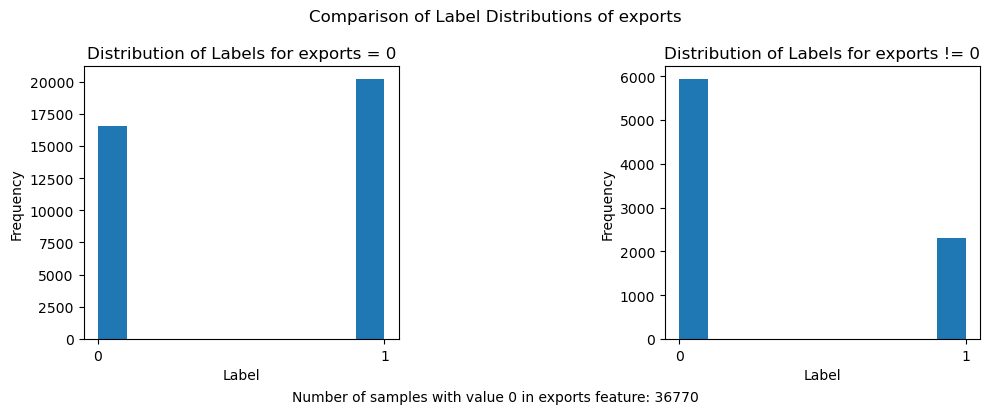

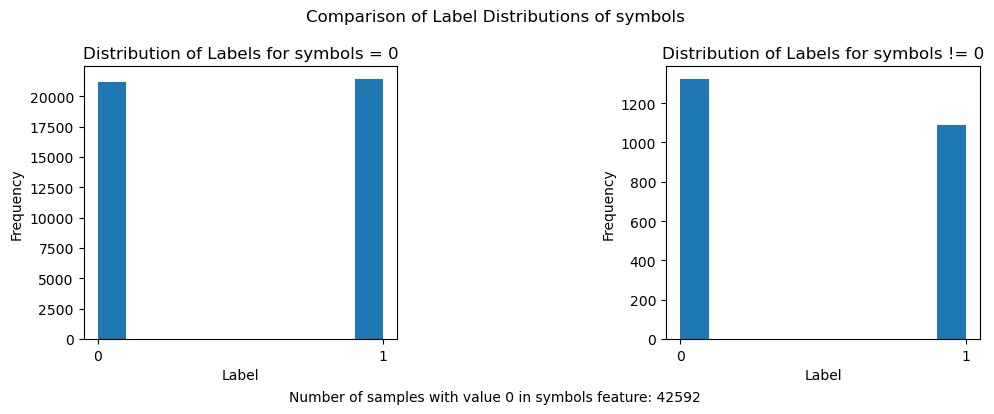

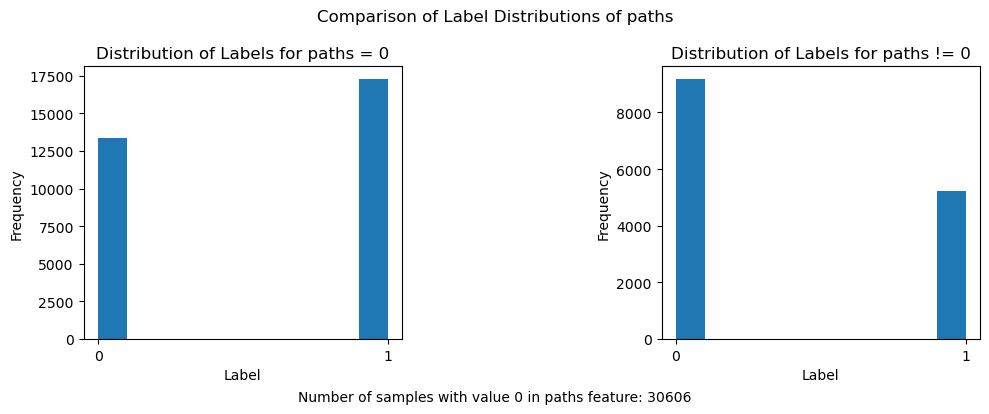

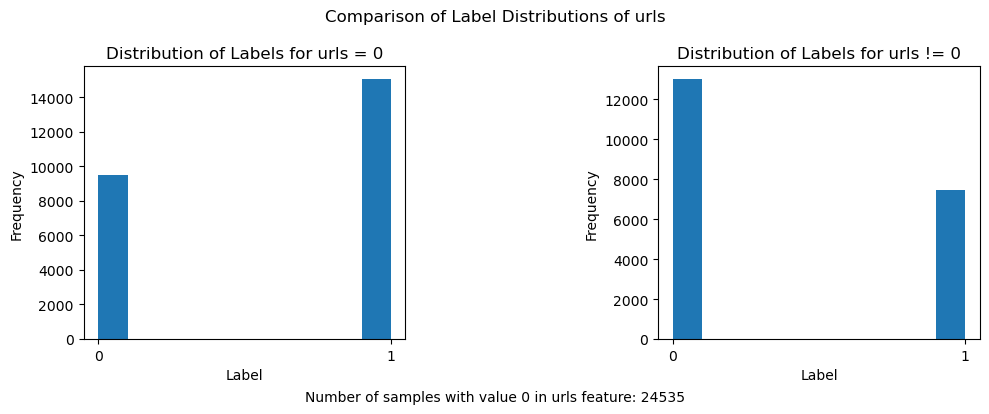

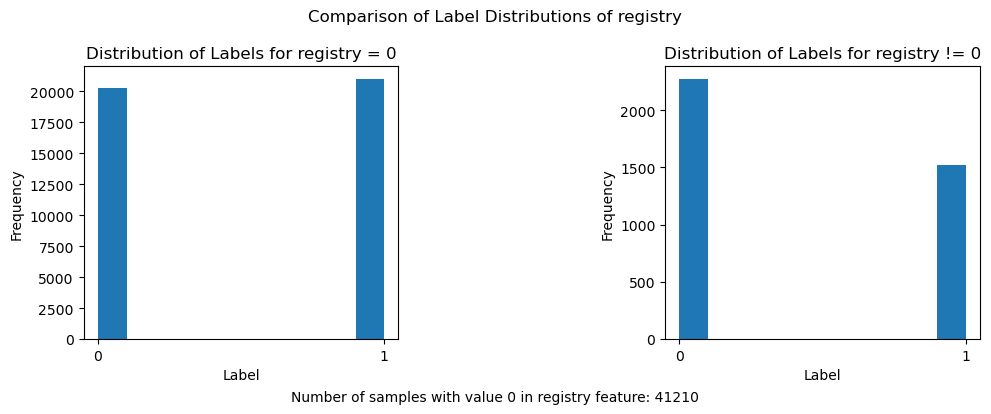

In [27]:
high_zeros_features = []

# Check for features with zero values occurring in more than half of the samples
for column in train_data_numeric_features.columns:
    if (train_data[column] == 0).sum() > (len(train_data) / 2):
       # prevent from checking the label feature
       if column != 'label':
        high_zeros_features.append(column)

print(f'High zeros features - {high_zeros_features}')

for feature in high_zeros_features:
    # Filter train_data for the current feature equal to 0
    feature_zero = train_data_numeric_features[train_data_numeric_features[feature] == 0]
    # Get labels for the current feature equal to 0
    labels_zero = feature_zero['label']

    # Filter train_data for the current feature not equal to 0
    feature_nonzero = train_data_numeric_features[train_data_numeric_features[feature] != 0]
    # Get labels for the current feature not equal to 0
    labels_nonzero = feature_nonzero['label']

    # Create subplots with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Plot histogram for the current feature equal to 0
    axes[0].hist(labels_zero)
    axes[0].set_xlabel('Label')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f'Distribution of Labels for {feature} = 0')
    axes[0].set_xticks([0, 1])  # Set x-axis ticks to match labels (0 and 1)

    # Plot histogram for the current feature not equal to 0
    axes[1].hist(labels_nonzero)
    axes[1].set_xlabel('Label')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'Distribution of Labels for {feature} != 0')
    axes[1].set_xticks([0, 1])  # Set x-axis ticks to match labels (0 and 1)

    plt.suptitle(f'Comparison of Label Distributions of {feature}')

    # Count the number of samples with value 0 for the current feature
    count_zero = len(train_data_numeric_features[train_data_numeric_features[feature] == 0])
    row = f"Number of samples with value 0 in {feature} feature: {count_zero}"

    plt.text(0.5, 0.01, row, horizontalalignment='center', verticalalignment='center', transform=fig.transFigure)

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()

Great! these are our conclusions from this explorization: <br>
-	The 'exports' feature has a large number of '0' values (~37K out of 45K samples) but still exhibits some variation between '0' and non-zero values, so it may still offer some utility to the model. After testing our model with and without this feature, we found it to have no significant contribution to the results. Therefore, we decided to remove it to reduce dimensionality.
-	The 'symbols' and 'registry' features predominantly consist of '0' values (~42K out of 45K samples) and show minimal variation in label distribution. These features will be removed.
-	The 'urls' and 'paths' features have a lower number of '0' values and distinct results between '0' and non-zero values, warranting further analysis and retention.

In [28]:
# Add 'symbols' and 'registry' to features to remove list:
features_to_remove = append_to_features_to_remove(features_to_remove, ['symbols', 'registry'])
features_to_remove

['sha256', 'symbols', 'registry']

## Correlation Matrix

We want to check corellation between features

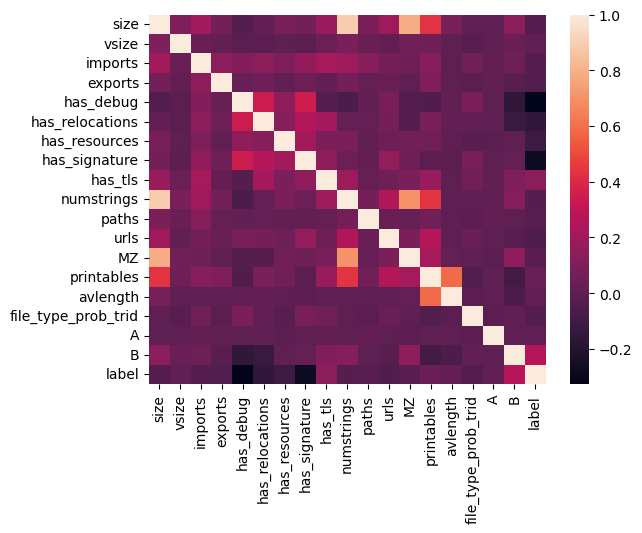

In [29]:
# Check the corellation between features:
corr_matrix = train_data.drop(columns=features_to_remove, inplace = False).corr()
corr_heatmap = sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns)

We can see that most of the features doesn't have high correlation between each other part of few that should be removed. <br>
We defined a threshold that above this correlation between 2 features we'll decide to remove this feature.

In [30]:
threshold = 0.85

# get upper triangle of correlation matrix

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# find features with correlation greater than the threshold

to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print(f'Features to drop are due to correlation higher than {threshold}: {to_drop}')


Features to drop are due to correlation higher than 0.85: ['numstrings']


In [31]:
features_to_remove = append_to_features_to_remove(features_to_remove, to_drop)
print(features_to_remove)

['sha256', 'symbols', 'registry', 'numstrings']


## Exploring Binary features

Here we can see for each binary feature how it's value effect on the lable (Contingency Table).

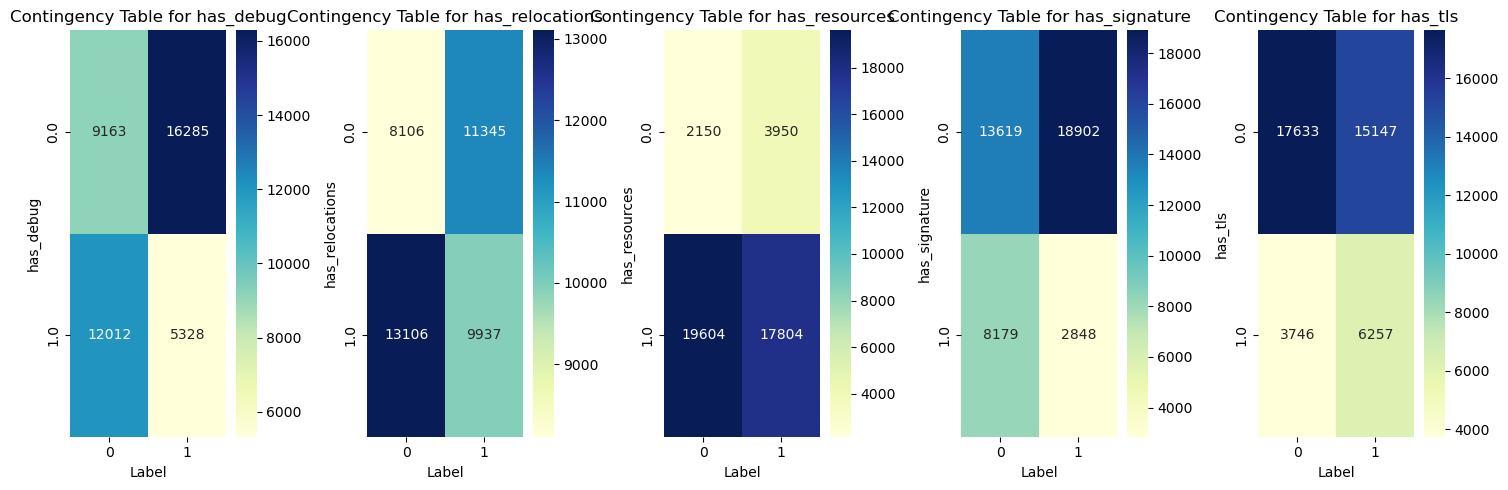

In [32]:
# Select the relevant features and label from your DataFrame
binary_features = ['has_debug', 'has_relocations', 'has_resources', 'has_signature', 'has_tls']
data_subset = train_data[binary_features + ['label']]

# Create contingency tables for each combination of features and label
contingency_tables = []
for feature in binary_features:
    contingency_table = pd.crosstab(index=data_subset[feature], columns=data_subset['label'])
    contingency_tables.append(contingency_table)

# Plot the contingency tables as heatmaps
fig, axes = plt.subplots(nrows=1, ncols=len(binary_features), figsize=(15, 5))
for i, (feature, table) in enumerate(zip(binary_features, contingency_tables)):
    sns.heatmap(table, annot=True, fmt='d', cmap='YlGnBu', ax=axes[i])
    axes[i].set_xlabel('Label')
    axes[i].set_ylabel(feature)
    axes[i].set_title(f'Contingency Table for {feature}')
plt.tight_layout()
plt.show()

Now we want to look deeper, we want to check if has any conecction between combination of several of them to the lable.

In [33]:
# Calculate the probability of label 1 for each feature combination
probabilities = {}
for r in range(1, len(binary_features) + 1):
    for combination in combinations(binary_features, r):
        # Filter the data based on the feature combination
        filtered_data = data_subset[data_subset[list(combination)].all(axis=1)]

        # Calculate the probability of label 1
        probability = filtered_data['label'].sum() / len(filtered_data)

        # Store the probability for the combination
        probabilities[combination] = probability

# Print the probabilities for each feature combination
for combination, probability in probabilities.items():
    print(f"Features: {combination}")
    print(f"Probability of Label 1: {probability:.4f}")
    print()

Features: ('has_debug',)
Probability of Label 1: 0.3172

Features: ('has_relocations',)
Probability of Label 1: 0.4361

Features: ('has_resources',)
Probability of Label 1: 0.4765

Features: ('has_signature',)
Probability of Label 1: 0.2873

Features: ('has_tls',)
Probability of Label 1: 0.6007

Features: ('has_debug', 'has_relocations')
Probability of Label 1: 0.3245

Features: ('has_debug', 'has_resources')
Probability of Label 1: 0.2994

Features: ('has_debug', 'has_signature')
Probability of Label 1: 0.2611

Features: ('has_debug', 'has_tls')
Probability of Label 1: 0.4471

Features: ('has_relocations', 'has_resources')
Probability of Label 1: 0.4110

Features: ('has_relocations', 'has_signature')
Probability of Label 1: 0.2601

Features: ('has_relocations', 'has_tls')
Probability of Label 1: 0.5948

Features: ('has_resources', 'has_signature')
Probability of Label 1: 0.2846

Features: ('has_resources', 'has_tls')
Probability of Label 1: 0.5936

Features: ('has_signature', 'has_tls

Although we found no strong connections for predicting malicious files, we discovered a few combinations that indicated non-malicious files (we choose the minimum): <br>

Features: ('has_relocations', 'has_signature')<br>
Probability of Label 1: 0.2601 => Probability of Label 0: 0.7399<br>

Therefore we build function that get data & binary features and return the data with one feature is combination of them. (only if all of them is 1 it'll be 1), so When this new feature is set to 1, it suggests that the file is likely not malicious.

In [34]:
binary_feature_to_combine = ['has_relocations', 'has_signature']

In [35]:
def pre_process_create_combined_feature(data, features,is_test = True):
    
    if not is_test:
        labels = data['label']
        data.drop(columns='label', inplace=True)
        
    new_feature = [1 if all(row[feat] == 1 for feat in features) else 0 for _, row in data.iterrows()]
    data['binary_combine'] = new_feature
    data = data.drop(columns=features)
    
    if not is_test:
        data['label'] = labels
    
    return data


## Exploring Categoricl Features

After we removed "Sha256" feature, we reamin with 2 categorical features - ["file_type_trid", "C"], let's see how they look.

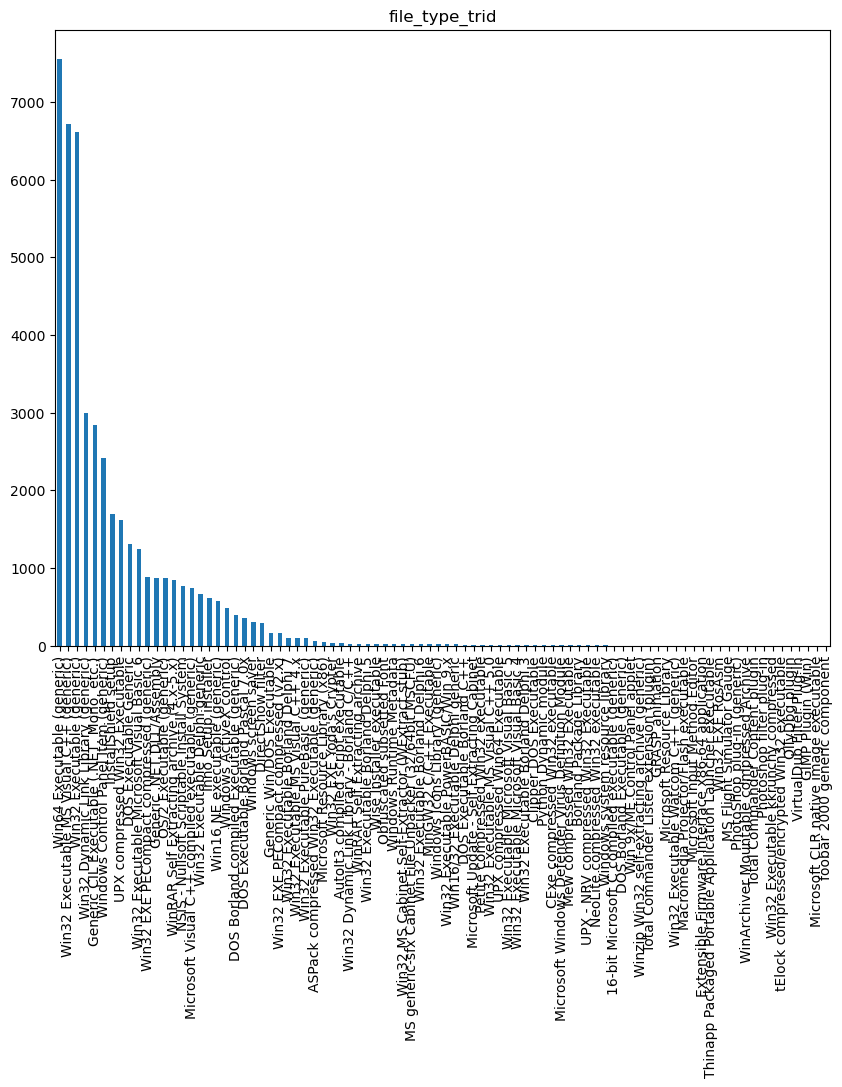

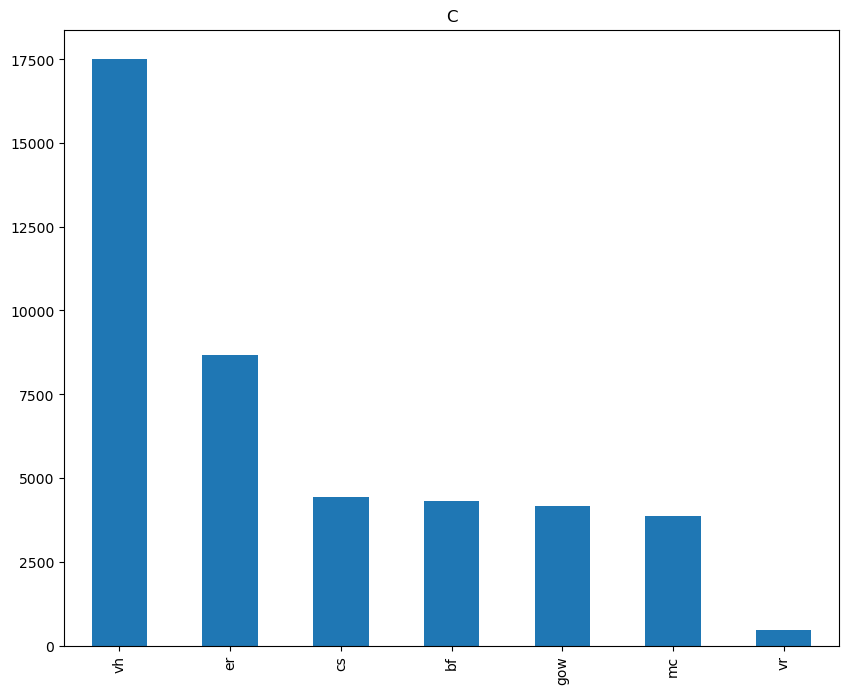

In [36]:
feature_file_type_trid_counts = train_data["file_type_trid"].value_counts()
feature_file_type_trid_counts.plot(kind="bar", figsize=(10, 8))
plt.title("file_type_trid")
plt.show()



feature_C_counts = train_data["C"].value_counts()
feature_C_counts.plot(kind="bar", figsize=(10, 8))
plt.title("C")
plt.show()

In C feature we saw that there are small amount of categories, so we decided to see how the label of each category look and if it contribute a significant data for predictions.

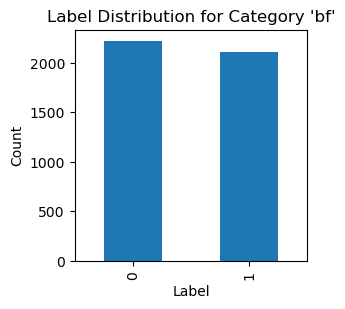

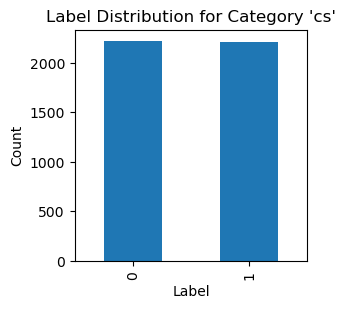

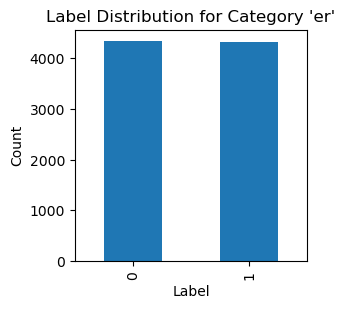

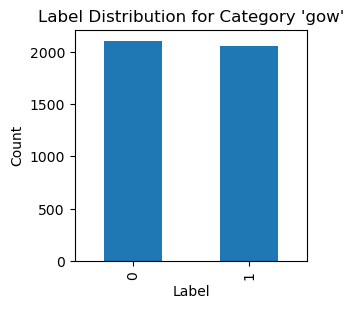

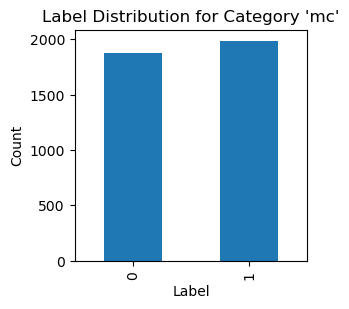

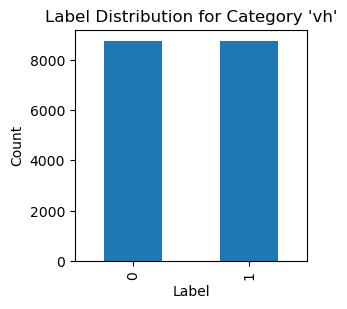

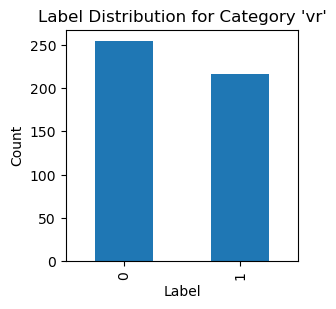

In [37]:
# Group the data by 'C' and 'label' and count the occurrences
grouped_data = train_data.groupby(['C', 'label']).size().unstack(fill_value=0)

# Plot the histogram for each category in 'C'
categories = grouped_data.index
for category in categories:
    category_data = grouped_data.loc[category]
    category_data.plot(kind='bar', stacked=True, figsize=(3, 3))
    plt.title(f"Label Distribution for Category '{category}'")
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()


We can see the lable divide in every category of C really equal, so we assume this feature can't help us a lot in the prediction so we add it to our list.

In [38]:
features_to_remove = append_to_features_to_remove(features_to_remove, 'C')
print(features_to_remove)

['sha256', 'symbols', 'registry', 'numstrings', 'C']


We can see in the feature 'file_type_trid' have a lot of categories and most of them not really common.<br>
we want to stay only with the most common so we build a function that change a bit the categories. (will help us later in the OneHotEncoder method to deal with categorial feature).<br>
We chose to divide it to 11 groups, all the categories that have more than 1000 samples (based on the graph we created) and the 'others' - all the others categories combined into one group.

In [39]:
def pre_process_reduce_categories_in_categorial_feature_train(train_data, feature,amount_categories = 11):
    # Identify the top categories for the feature
    top_categories = train_data[feature].value_counts().nlargest(amount_categories).index

    # Replace all other categories with "others" for the feature in the data copy
    train_data.loc[~train_data[feature].isin(top_categories), feature] = "others"
    
    return train_data, top_categories


In [40]:
def pre_process_reduce_categories_in_categorical_feature_test(test_data, feature, top_categories):
    
    # Replace all other categories with "others" for the feature in the data copy
    test_data.loc[~test_data[feature].isin(top_categories), feature] = "others"
    
    return test_data

In [41]:
check_d = train_data.drop(columns=features_to_remove, inplace=False).copy()
check_d, train_top_categories = pre_process_reduce_categories_in_categorial_feature_train(check_d,"file_type_trid")



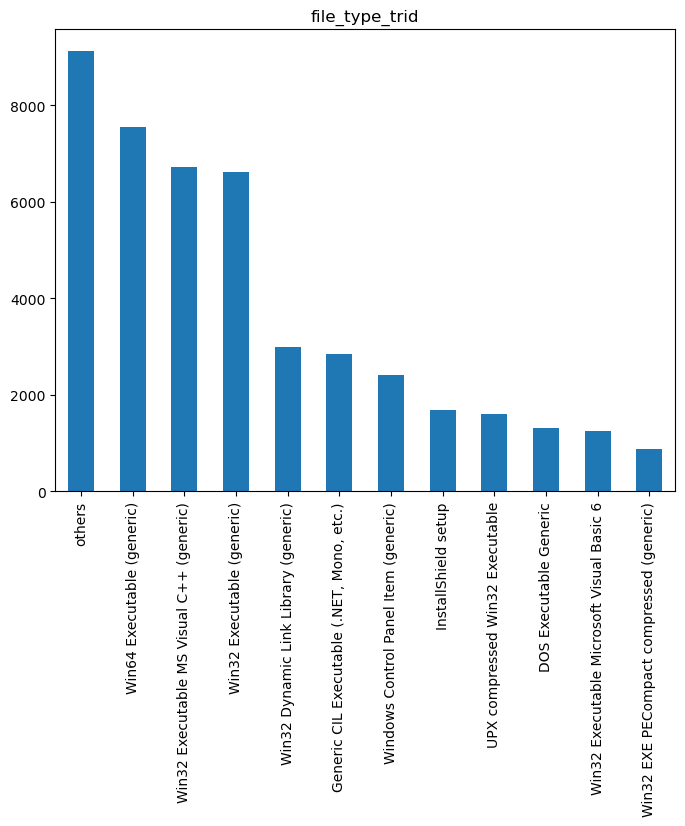

In [42]:

feature_file_type_trid_counts = check_d["file_type_trid"].value_counts()
feature_file_type_trid_counts.plot(kind="bar", figsize=(8, 6))
plt.title("file_type_trid")
plt.xticks(rotation=90)
plt.show()



## Explore other features

Now we want to get some data on each feature that we didn't explore yet and try to understand them:

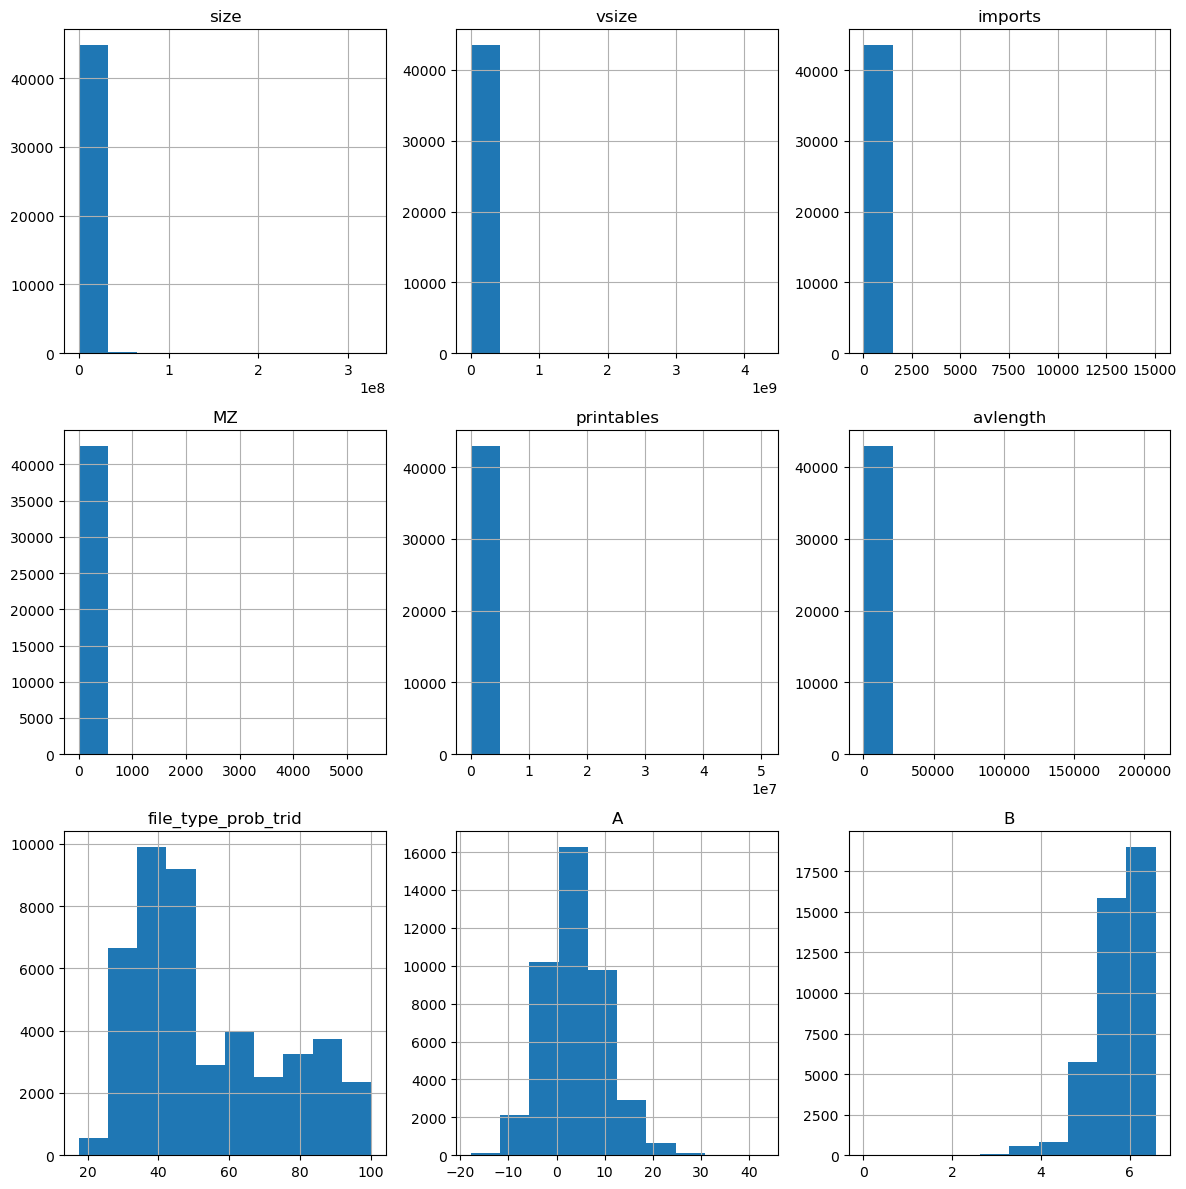

In [43]:
train_data.drop(columns=features_to_remove + high_zeros_features + binary_features + ['label'], inplace = False).hist(figsize=(12, 12))
plt.tight_layout()
plt.show()

We noticed that all these features - ['size','vsize','imports', 'MZ', 'printables', 'avlenght'] are having only one huge bar in the histogram but long X axis. <br>
Let's try to explore them specificly:

In [44]:
features_to_explore = ['size','vsize','imports', 'MZ', 'printables', 'avlength']
data_to_explore = train_data[features_to_explore]

We want to try to set a threshold as the upper limit of the one big bar we saw in the histograms plots of these features. as we think that most of the interesting data is there. 
Let's try to set this threshold, count the values above it, and plot the values under it, for each one of the features:

In [45]:
data_to_explore.describe()

,size,vsize,imports,MZ,printables,avlength
count,4.500000e+04,4.356600e+04,43679.000000,42691.000000,4.298800e+04,42956.000000
mean,1.485874e+06,1.999065e+06,106.046338,16.029257,1.195781e+05,32.202220
std,4.540466e+06,2.291081e+07,210.896747,72.839680,5.663482e+05,1098.700899
min,2.980000e+02,5.440000e+02,0.000000,1.000000,5.000000e+00,5.000000
25%,1.075200e+05,1.228800e+05,1.000000,1.000000,6.064000e+03,7.447368
50%,4.829210e+05,4.218880e+05,28.000000,4.000000,2.286450e+04,12.024923
75%,1.227278e+06,1.593344e+06,152.000000,11.000000,7.623875e+04,17.329338
max,3.253537e+08,4.278288e+09,15047.000000,5449.000000,5.034687e+07,207990.925620


The 95th percentile value of size is: 5749011.299999976


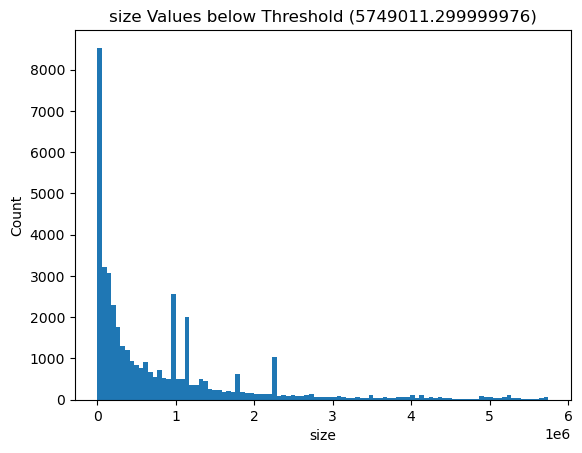

values above threshold: size       vsize      imports  MZ      printables  avlength 
7288832    7340032.0  537.0    52.0    975372.0    13.692699    4
5768192    5898240.0  565.0    55.0    614481.0    11.928427    3
7165440    7294976.0  539.0    45.0    919397.0    13.266529    3
6152704    6205440.0  559.0    64.0    605839.0    11.357636    3
6306816    6361088.0  508.0    44.0    809191.0    13.540226    3
                                                               ..
7177216    7307264.0  564.0    55.0    918462.0    13.316833    1
7165440    7294976.0  539.0    45.0    919507.0    13.264480    1
                                       919453.0    13.265997    1
                                       919445.0    13.265882    1
325353693  331776.0   211.0    5449.0  10217142.0  6.498375     1
Length: 1760, dtype: int64
The 95th percentile value of vsize is: 7417856.0


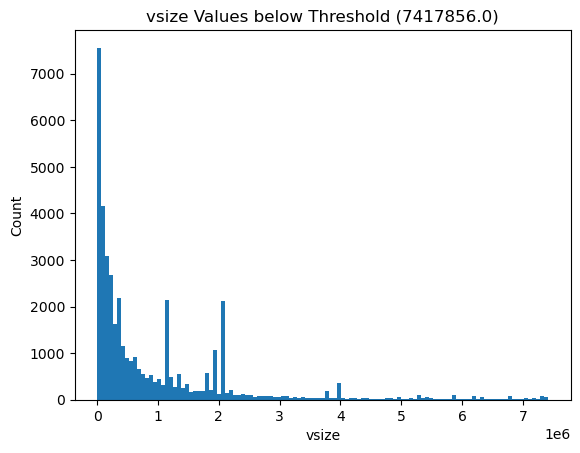

values above threshold: size       vsize        imports  MZ      printables  avlength
3998208    11485184.0   14.0     47.0    117034.0    5.778030    3
3474432    8089600.0    11.0     39.0    97563.0     5.795248    2
3897856    9355264.0    11.0     40.0    119048.0    5.869349    2
4122624    10334208.0   13.0     39.0    127449.0    5.856762    2
4876288    14602240.0   15.0     49.0    146434.0    5.757411    2
                                                                ..
3998208    11485184.0   14.0     47.0    117087.0    5.777509    1
                                         117076.0    5.777537    1
                                         117070.0    5.777811    1
                                                     5.777526    1
127462400  127488000.0  152.0    1984.0  3317193.0   5.610617    1
Length: 1757, dtype: int64
The 95th percentile value of imports is: 442.0


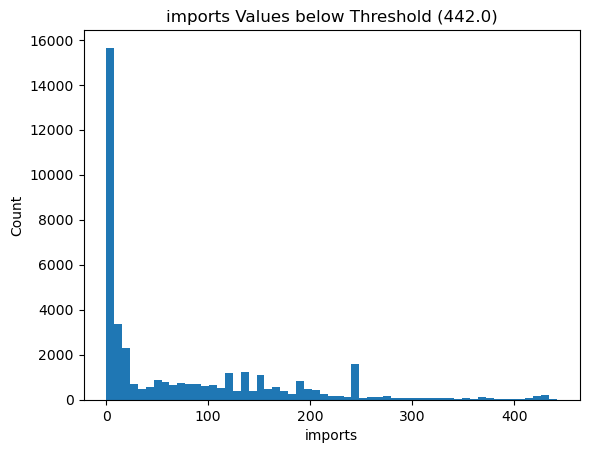

values above threshold: size      vsize       imports  MZ     printables  avlength 
1569280   2150400.0   580.0    2.0    156168.0    11.149283    5
7288832   7340032.0   537.0    52.0   975372.0    13.692699    4
1204224   1204224.0   449.0    4.0    28574.0     10.025965    3
1155090   1171456.0   566.0    3.0    34871.0     12.759239    3
5768192   5898240.0   565.0    55.0   614481.0    11.928427    3
                                                              ..
2002536   2306048.0   594.0    1.0    251780.0    11.405146    1
1999872   2052096.0   469.0    1.0    376266.0    13.186122    1
1998848   2035712.0   752.0    13.0   90950.0     13.641818    1
1994491   2830336.0   751.0    3.0    127972.0    23.339777    1
80854560  81141760.0  2280.0   103.0  5090438.0   15.161529    1
Length: 1771, dtype: int64
The 95th percentile value of MZ is: 55.0


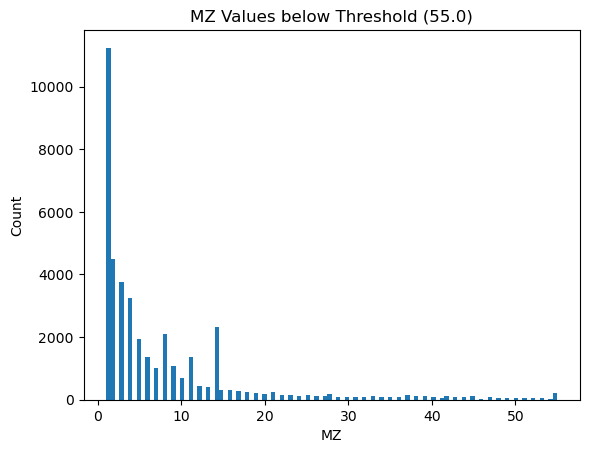

values above threshold: size       vsize      imports  MZ      printables  avlength 
4418432    159744.0   120.0    60.0    118577.0    5.845551     5
3655704    3670016.0  86.0     62.0    100336.0    6.367305     4
6152704    6205440.0  559.0    64.0    605839.0    11.357636    3
3391416    3395584.0  89.0     66.0    98234.0     6.304326     3
4418432    159744.0   120.0    60.0    118582.0    5.845509     3
                                                               ..
5093386    90112.0    88.0     79.0    171018.0    7.008360     1
5090971    331776.0   94.0     75.0    144106.0    6.103859     1
5088001    331776.0   94.0     74.0    144229.0    6.120735     1
5083047    339968.0   190.0    74.0    138397.0    5.951023     1
325353693  331776.0   211.0    5449.0  10217142.0  6.498375     1
Length: 1764, dtype: int64
The 95th percentile value of printables is: 614460.0


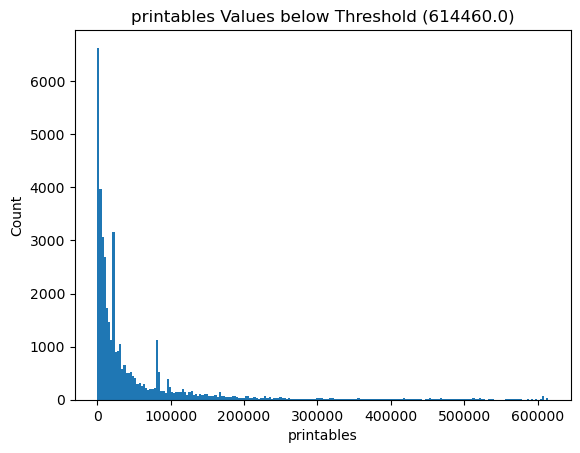

values above threshold: size       vsize      imports  MZ      printables  avlength  
2261008    1912832.0  17.0     11.0    1399909.0   240.616879    5
2261153    1912832.0  17.0     11.0    1405747.0   207.001473    4
7288832    7340032.0  537.0    52.0    975372.0    13.692699     4
2261033    1912832.0  17.0     11.0    1399909.0   240.616879    4
2260959    1912832.0  17.0     11.0    1404769.0   206.887923    4
                                                                ..
2261153    1912832.0  17.0     11.0    1404774.0   206.858195    1
                                       1399909.0   240.616879    1
2261152    1912832.0  17.0     11.0    1410607.0   181.709004    1
                                       1409629.0   181.606416    1
325353693  331776.0   211.0    5449.0  10217142.0  6.498375      1
Length: 1676, dtype: int64
The 95th percentile value of avlength is: 40.88021570271839


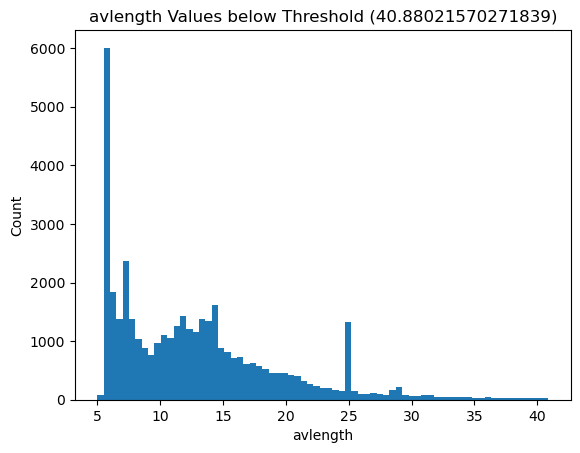

values above threshold: size      vsize      imports  MZ    printables  avlength     
2048      8192.0     0.0      1.0   177.0       59.000000        5
2261008   1912832.0  17.0     11.0  1399909.0   240.616879       5
2261153   1912832.0  17.0     11.0  1405747.0   207.001473       4
147456    147456.0   75.0     29.0  83010.0     360.913043       4
2260959   1912832.0  17.0     11.0  1404769.0   206.887923       4
                                                                ..
184248    196608.0   1.0      2.0   85822.0     42.846730        1
183069    270336.0   9.0      2.0   89353.0     260.504373       1
181760    192512.0   0.0      1.0   423.0       52.875000        1
181248    188416.0   0.0      1.0   294.0       73.500000        1
50388992  57344.0    59.0     2.0   50333804.0  207990.925620    1
Length: 1647, dtype: int64


In [46]:
# Calculate the 95th percentile for each feature
percentiles = data_to_explore.quantile(0.95)

# Print the 95th percentile values
for feature, threshold in percentiles.items():
    print(f"The 95th percentile value of {feature} is: {threshold}")


    # Plot the values below the threshold
    values_below_threshold = data_to_explore[data_to_explore[feature] <= threshold]
    plt.hist(values_below_threshold[feature], bins='auto')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(f'{feature} Values below Threshold ({threshold})')
    plt.show()

    # Count the values above threshold:
    print(f'values above threshold: {data_to_explore[data_to_explore[feature] > threshold].value_counts()}')

All the plots looks like a Log-Normal Distribution. <br>
The log normal distribution may seem similar to the normal distribution but it has a few catches:

- It’s skewed to the right, meaning it has a positive fat-tail.
- It only contains positive values.

And it's exactly what we see here!

let's try to plot the log-transfrom features until the 95 percentile:


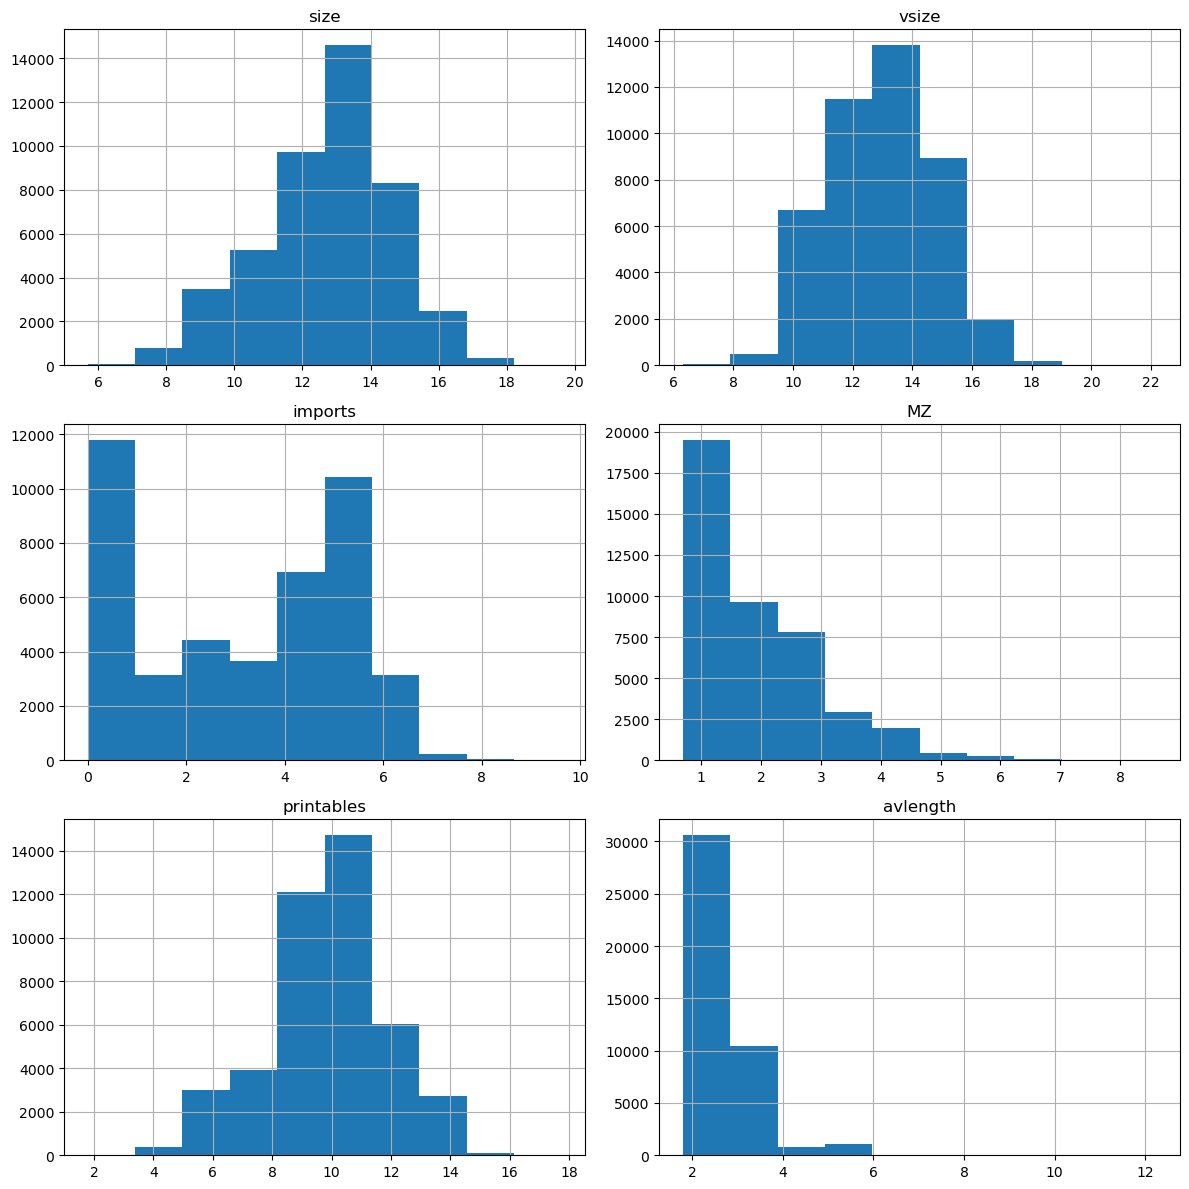

In [47]:
# Apply feature transformation techniques to spread out the values
transformed_data = np.log1p(train_data[features_to_explore])  # Apply log transformation to the features
transformed_data.hist(figsize=(12, 12))  # Plot the histograms of transformed features
plt.tight_layout()
plt.show()

We observed that ['size', 'vsize', 'printables'] closely resemble a normal distribution after transformation (although not exact, we assume they are). As we prefer working with features that exhibit a normal distribution, it facilitates outlier reduction and offers advantages for future analysis. Consequently, we transformed all features that exhibited a similar normal distribution after the transformation.

In [48]:
# Select the features you want to transform to log scale
features_scale_to_log = ['size','vsize','printables']

def pre_process_apply_log_transformation(data, features, is_test):
    data_copy = data.copy()

    if not is_test:
        labels = data_copy['label']
        data_copy.drop(columns='label', inplace=True)
    
    for feature in features:
        transformed_feature = np.log1p(data_copy[feature]) # Use np.log() for natural logarithm
        data_copy[feature + '_logscale'] = transformed_feature
        data_copy = data_copy.drop(columns=feature)
    
    if not is_test:
        data_copy['label'] = labels

    return data_copy

## Size And V-Size Exploration

The features 'size' and 'vsize' describe diferrent size aspect of the files.<br>
So another thing we want to check if a significant difference between the 'size' to the 'vsize' of the files can indicate malicious files.<br>
Therefore we create new feature that is the absolute difference between the two and now we'll see if it affects the results.

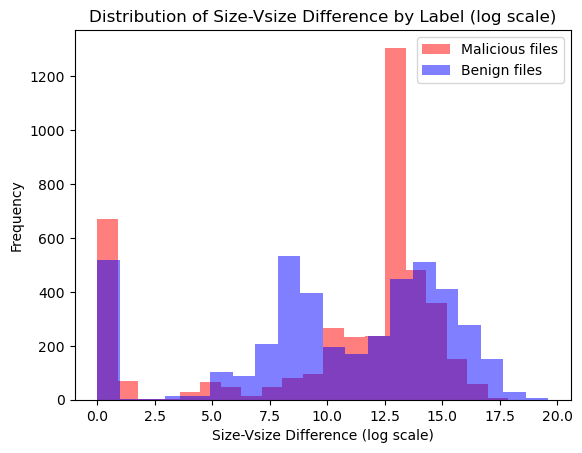

In [49]:
Data_size_vsize = train_data.drop(columns=features_to_remove, inplace=False).copy()
Data_size_vsize['size_vsize_diff'] = Data_size_vsize['size'] - Data_size_vsize['vsize'].abs()
Data_size_vsize['size_vsize_diff'] = np.log1p(Data_size_vsize['size_vsize_diff']) #change to logscale based on what we did before

# Separate the data based on the label
malicious_files = Data_size_vsize[Data_size_vsize['label'] == 1]
benign_files = Data_size_vsize[Data_size_vsize['label'] == 0]

# Filter out non-finite values from 'size_vsize_diff'
malicious_diff = malicious_files['size_vsize_diff'].loc[np.isfinite(malicious_files['size_vsize_diff'])]
benign_diff = benign_files['size_vsize_diff'].loc[np.isfinite(benign_files['size_vsize_diff'])]

# Plot the distribution of 'size_vsize_diff' for malicious files
plt.hist((malicious_diff), bins=20, color='red', alpha=0.5, label='Malicious files')

# Plot the distribution of 'size_vsize_diff' for benign files
plt.hist((benign_diff), bins=20, color='blue', alpha=0.5, label='Benign files')

plt.xlabel('Size-Vsize Difference (log scale)')
plt.ylabel('Frequency')
plt.title('Distribution of Size-Vsize Difference by Label (log scale)')
plt.legend()
plt.show()


As we can see in the most of the examples the difference between the 'size' to the 'vsize' of the files not indicate malicious files, (we realise it from the Frequency that stay low), so we decided to proceed without including it in our analysis.

#### Concluding the exploration phase, we acknowledge that we have not discussed the features ['A', 'file_type_prob_trid', 'B']. We assume that the distribution of 'A' is normal, while the distributions of the other two features are unknown and will be treated as such. This part helped us to remove features based on the exploration we did. Moving forward, we will focus on the preprocessing stage.

In [50]:
features_to_remove

['sha256', 'symbols', 'registry', 'numstrings', 'C']

# Part 2 - Pre Processing

In [51]:
# Configurable parameters
iqr_value = 1.5

data_to_process = pre_process_apply_log_transformation(train_data.drop(columns=features_to_remove, inplace=False).copy(), features_scale_to_log, False)

continuous_features = list(data_to_process.drop(columns=binary_features + ['label']).select_dtypes(include='number').columns)
categorical_features = list(data_to_process.select_dtypes(include=['object', 'category']).columns)

print(f'binary features: {binary_features}\ncontinuous features: {continuous_features}\ncategorical features: {categorical_features}')

features_numerics_normal_distribution = ['size_logscale', 'vsize_logscale', 'printables_logscale', 'A']
features_numerics_unknown_distribution = ['exports','paths','urls', 'MZ', 'avlength', 'file_type_prob_trid', 'B', 'imports']


binary features: ['has_debug', 'has_relocations', 'has_resources', 'has_signature', 'has_tls']
continuous features: ['imports', 'exports', 'paths', 'urls', 'MZ', 'avlength', 'file_type_prob_trid', 'A', 'B', 'size_logscale', 'vsize_logscale', 'printables_logscale']
categorical features: ['file_type_trid']


### Are there outliers in the data? If so, you must remove them or at least give explanation about it.

We have three types of features: continuous, binary, and categorical.<br>
Outliers are not a concern in binary features (it can be only 0/1).<br>
For categorical features, rare categories are grouped as 'others' instead of being treated as outliers.<br>
Outlier detection is primarily focused on the continuous features, which we divided into two cases:
<br>
1. features that we assumed were normally distributed - Here we used the IQR (Interquartile Range) method that identifies outliers by calculating the range between the 25th and 75th percentiles of a dataset. Data points below Q1 minus a threshold or above Q3 plus the same threshold are considered outliers.
2. features we couldn't diagnose their distribution - Here we used Isolation Forest from pyod library (we were shown it in lecture 12). It constructs random decision trees and measures the isolation of data points. Outliers have shorter average path lengths in the trees, making them easier to isolate. The algorithm assigns anomaly scores to identify outliers from the dataset.

In [52]:
def pre_process_handle_outliers_unknownDistribution_train(data, features, thres=99):

    # Select the columns corresponding to the features
    data_selected = data[features].values

    # Handle missing values using mean imputation
    imputer = SimpleImputer(strategy='mean')
    data_selected_imputed = imputer.fit_transform(data_selected)

    # Fit the Isolation Forest model
    model = IForest()
    model.fit(data_selected_imputed)

    # Predict the anomaly scores for each data point
    anomaly_scores = model.decision_function(data_selected_imputed)
    print(anomaly_scores)
    print(len(anomaly_scores))

    # Initialize dictionaries to store the most common values and thresholds for each feature
    most_common_values = {}
    feature_thresholds = {}

    for feature in features:
        # Set a threshold for outlier detection
        threshold = np.percentile(anomaly_scores, thres)
        feature_thresholds[feature] = threshold

        # Identify outliers based on the anomaly scores
        outliers = np.where(anomaly_scores > threshold)[0]

        # Remove duplicate values from outliers
        outliers = np.unique(outliers)

        # Print the number of outliers detected for the current feature
        print("Number of outliers detected for feature '{}' ('unknown distribution'): {}".format(feature, len(outliers)))

        # Replace outliers with the most common examples of the current feature
        non_missing_outliers = np.intersect1d(outliers, data[data[feature].notna()].index)
        most_common = data[~data.index.isin(non_missing_outliers)][feature].mode().values[0]
        most_common_values[feature] = most_common
        data.loc[data.index.isin(non_missing_outliers), feature] = most_common

    # Print the number of data points after handling outliers
    print("Number of data points after handling outliers:", len(data))

    return data, feature_thresholds, most_common_values 

In [53]:
def pre_process_handle_outliers_normals_train(data, features, iqr_value=1.5):
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    lower_thresholds = {}
    upper_thresholds = {}
    feature_medians = {}

    for feature in features:
        lower_threshold = Q1[feature] - iqr_value * IQR[feature]
        upper_threshold = Q3[feature] + iqr_value * IQR[feature]

        lower_thresholds[feature] = lower_threshold
        upper_thresholds[feature] = upper_threshold

        outliers = ((data[feature] < lower_threshold) | (data[feature] > upper_threshold))

        # Replace outliers with the median of the feature
        median = data[~outliers][feature].median()
        data.loc[outliers, feature] = median
        feature_medians[feature] = median

    # Print the number of outliers detected
    num_outliers = outliers.sum()
    print("Number of outliers detected 'normal distribution':", num_outliers)

    # Print the number of data points after handling outliers
    num_data_points = len(data)
    print("Number of data points after handling outliers:", num_data_points)

    thresholds = {
        'lower': lower_thresholds,
        'upper': upper_thresholds
    }

    return data, thresholds, feature_medians

In [54]:
def pre_process_handle_outliers_normals_test(data, features, thresholds, medians):
    lower_thresholds = thresholds['lower']
    upper_thresholds = thresholds['upper']

    for feature in features:
        lower_threshold = lower_thresholds[feature]
        upper_threshold = upper_thresholds[feature]

        outliers = ((data[feature] < lower_threshold) | (data[feature] > upper_threshold))

        # Replace outliers with the median of the feature from the training data
        median = medians[feature]
        data.loc[outliers, feature] = median

    # Print the number of outliers replaced
    num_outliers_replaced = outliers.sum()
    print("Number of outliers replaced 'normal distribution':", num_outliers_replaced)

    # Print the number of data points after handling outliers
    num_data_points = len(data)
    print("Number of data points after handling outliers:", num_data_points)

    return data

We chose not to remove the outliers for two primary reason: Firstly, we aimed to devise a solution that can be applied to our test data as well, Secondly it cause us for overfitting. Instead, for normally distributed features, we replaced the outliers with the median value. We observed that dealing with outliers using the Isolation Forest harmed the results, so we decided only to address outliers in the normal features.

### Dealing with missing data:

Identify Missing Data

In [55]:
# Check the number of NULL values of each feature: 
train_data.drop(columns=features_to_remove, inplace = False).isnull().sum()

size                      0
vsize                  1434
imports                1321
exports                1563
has_debug              2212
has_relocations        2506
has_resources          1492
has_signature          1452
has_tls                2217
paths                  2764
urls                   1759
MZ                     2309
printables             2012
avlength               2044
file_type_trid            0
file_type_prob_trid       0
A                      2773
B                      2893
label                     0
dtype: int64

We can see that most of the features have significant number of NULL values. <br>
The only categorical feature - 'file_type_trid' does not have a NULL values. in the beginning we thought it means that we can ignore the missing values method for categorical features. But then we realized that it's only the train data and maybe in the validation or test data we'll encounter a NULL values in this feature and we provide a solution for it.

For start, we tried to remove rows with missing data and continue to the models, only to get a first scoring and benchmark for our work.

In [56]:
# The function:
def pre_process_remove_null(data):
    data_drop_null = data.dropna()
    X, y = data_drop_null.values[:,:-1], data_drop_null.values[:, -1]
    print(f'Data shape after removing NULL values: \n X.shape: {X.shape}, y.shape: {y.shape}')
    return data_drop_null

In [57]:
# Implement on the data:
data_drop_null = pre_process_remove_null(train_data.drop(columns=features_to_remove, inplace = False))

Data shape after removing NULL values: 
 X.shape: (22232, 18), y.shape: (22232,)


We saw it drops more than 50% of our data, and we are loosing a lot of data because of that. <br>
So we tried another, and more smart ways to deal with the missing data: 

To impute the missing data, we utilized the SimpleImputer. For this purpose, we developed a function capable of implementing the imputation process based on the specified strategy and features. This approach enabled us to handle different feature types and test various strategies accordingly.<br>
After researching, we found that the appropriate imputation strategy depends on the assumption of missing values and data distribution.<br>
If missing values are random and the data follows a normal distribution, using the 'mean' strategy is suitable.<br>
For data with outliers or skewness, the 'median' strategy is more robust.<br>
The 'most_frequent' strategy is effective for categorical or discrete features.<br>
Considering these factors and assuming random missing values in normal distribution features, we implemented our methodology to handle missing data.<br>
Although the only categorical feature, 'file_type_trid,' did not have any NULL values in the train data, we realized the possibility of encountering them in the validation or test data.

In [58]:
def pre_process_impute_features_train(data, strategy, features):
    data_copy = data.copy()
    
    # Create an instance of SimpleImputer with the specified strategy
    imputer = SimpleImputer(strategy=strategy)
    
    # Fit the imputer to the data and transform the missing values
    imputed_data = imputer.fit_transform(data_copy[features])

    # Create a new DataFrame with the imputed values
    imputed_df = pd.DataFrame(imputed_data, columns=features)

    data_copy.drop(columns =features, inplace =True)
    
    return pd.concat([imputed_df.reset_index(drop=True), data_copy.reset_index(drop=True)], axis=1), imputer

In [59]:
def pre_process_impute_features_test(data, features, imputer):
    data_copy = data.copy()
    
    # Fit the imputer to the data and transform the missing values
    imputed_data = imputer.transform(data_copy[features])

    # Create a new DataFrame with the imputed values
    imputed_df = pd.DataFrame(imputed_data, columns=features)

    data_copy.drop(columns =features, inplace =True)
    
    return pd.concat([imputed_df.reset_index(drop=True), data_copy.reset_index(drop=True)], axis=1)

In [60]:
data_after_sim_imp, train_normal_features_imputer = pre_process_impute_features_train(data_to_process, 'mean', features_numerics_normal_distribution)
print (data_after_sim_imp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   size_logscale        45000 non-null  float64
 1   vsize_logscale       45000 non-null  float64
 2   printables_logscale  45000 non-null  float64
 3   A                    45000 non-null  float64
 4   imports              43679 non-null  float64
 5   exports              43437 non-null  float64
 6   has_debug            42788 non-null  float64
 7   has_relocations      42494 non-null  float64
 8   has_resources        43508 non-null  float64
 9   has_signature        43548 non-null  float64
 10  has_tls              42783 non-null  float64
 11  paths                42236 non-null  float64
 12  urls                 43241 non-null  float64
 13  MZ                   42691 non-null  float64
 14  avlength             42956 non-null  float64
 15  file_type_trid       45000 non-null 

In [61]:
data_after_sim_imp, train_unknown_features_imputer = pre_process_impute_features_train(data_after_sim_imp, 'median', features_numerics_unknown_distribution)
print (data_after_sim_imp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   exports              45000 non-null  float64
 1   paths                45000 non-null  float64
 2   urls                 45000 non-null  float64
 3   MZ                   45000 non-null  float64
 4   avlength             45000 non-null  float64
 5   file_type_prob_trid  45000 non-null  float64
 6   B                    45000 non-null  float64
 7   imports              45000 non-null  float64
 8   size_logscale        45000 non-null  float64
 9   vsize_logscale       45000 non-null  float64
 10  printables_logscale  45000 non-null  float64
 11  A                    45000 non-null  float64
 12  has_debug            42788 non-null  float64
 13  has_relocations      42494 non-null  float64
 14  has_resources        43508 non-null  float64
 15  has_signature        43548 non-null 

In [62]:
data_after_sim_imp, train_binary_features_imputer = pre_process_impute_features_train(data_after_sim_imp, 'most_frequent', binary_features)
print (data_after_sim_imp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   has_debug            45000 non-null  float64
 1   has_relocations      45000 non-null  float64
 2   has_resources        45000 non-null  float64
 3   has_signature        45000 non-null  float64
 4   has_tls              45000 non-null  float64
 5   exports              45000 non-null  float64
 6   paths                45000 non-null  float64
 7   urls                 45000 non-null  float64
 8   MZ                   45000 non-null  float64
 9   avlength             45000 non-null  float64
 10  file_type_prob_trid  45000 non-null  float64
 11  B                    45000 non-null  float64
 12  imports              45000 non-null  float64
 13  size_logscale        45000 non-null  float64
 14  vsize_logscale       45000 non-null  float64
 15  printables_logscale  45000 non-null 

For categorical features we decided to add a 'missing' category for the categorical features. this will add in the end to the 'others' category that we'll build for the categorical features.

In [63]:
def pre_process_impute_categoricals(data):
    # Create a copy of the DataFrame to preserve the original data
    data_imputed = data.copy()

    # Impute missing values in categorical features with 'missing' value
    for feature in categorical_features:
        data_imputed[feature] = data_imputed[feature].fillna('missing')

    return data_imputed

We explored the K-nearest neighbors (KNN) imputer method but found it to be time-consuming without providing better results. Hence, we chose not to use it. Additionally, our experiments confirmed that the most effective approach aligned with our research findings. we kept this function to show the process. (the function isn't use).

In [64]:
def pre_process_impute_knn(data, features_to_impute, n_neighbors=5):
    # Split the data into complete values and missing values
    data_complete = data.dropna(subset=features_to_impute, inplace = False)
    data_missing = data[data[features_to_impute].isna().any(axis=1)]

    # Perform feature scaling on complete data
    scaler = StandardScaler()
    scaled_data_complete = scaler.fit_transform(data_complete[features_to_impute])

    # Scale the missing data using the same scaler
    scaled_data_missing = scaler.transform(data_missing[features_to_impute])

    # Impute missing values using KNN imputer
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_data_missing = imputer.fit_transform(scaled_data_missing)

    # Create DataFrame with imputed values
    imputed_data = pd.DataFrame(imputed_data_missing, columns=features_to_impute)

    # Merge the imputed values with the original data
    data_imputed = pd.concat([imputed_data, data.drop(columns=features_to_impute)], axis=1)

    return data_imputed

### Dealing with categorical features

For start, We tried to remove the categorical features.

In [65]:
# The function
def pre_process_remove_categorical_features(data):
    # Identify Categorical Features by Data Type
    categorical_features = list(data.select_dtypes(include=['object', 'category']).columns)
    
    # Separate Numerical and Categorical Features
    numerical_features = [col for col in data.columns if col not in categorical_features]
    
    # Create a New Data Set
    new_data = data[numerical_features].copy()
    
    return new_data

We realize after our models, do not support categorical features, so we transformed our categorical feature into a numeric representation.<br>
We opted to use the OneHotEncoder from the sklearn library instead of alternatives like get_dummies from pandas. This choice ensures compatibility with future test data, enabling us to handle new examples that were not seen during training.

In [66]:
def pre_process_one_hot_to_category_feature(data,feature):
    data_copy = data.copy()
    
    # Perform one-hot encoding on the modified data
    encoder = OneHotEncoder(sparse=False)  # Set sparse=False to get a dense array
    encoded_features = encoder.fit_transform(data_copy[[feature]])

    # Retrieve the original column names
    column_names = data[[feature]].columns

    # Retrieve the unique categories from the encoder
    categories = encoder.categories_
    #feature
    # Create the encoded feature names
    encoded_feature_names = [f"{column}_{category}" for column, category_list in zip(column_names, categories) for category in category_list]

    # Create a new DataFrame with the encoded features
    encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

    data_copy.drop(columns =feature, inplace =True)
    
    return pd.concat([encoded_df.reset_index(drop=True), data_copy.reset_index(drop=True)], axis=1)


### Is the data normalized? If not - should they be normalized? What is the importance of normalizing the data in the problem?

Our data isn't normalized, we want to normalized it because few reasons could help us later:<br>
1. It brings features to a similar scale, preventing dominance by larger magnitudes and enabling fair comparisons between different features.
2. Many algorithms assume similar feature scales, so normalization enhances their performance and convergence speed, leading to more accurate predictions.
3. Normalized data allows for meaningful interpretation of feature importance, as coefficients or weights become comparable and easier to understand.
4. Distance-based techniques we gonna use in our models, like clustering or KNN, heavily rely on feature scales. Normalization ensures precise distance calculations, improving the effectiveness of these methods.<br><br>

We used in MinMaxScaler method that transforms features by scaling them to a specified range between 0 and 1. It calculates the minimum and maximum values of each feature and then scales the values accordingly, preserving the original data distribution.

In [67]:
#The Function:
def pre_process_normalize_data(data):

    # Select the features to be normalized
    features_to_normalize = data.columns

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Normalize only the selected features
    data[features_to_normalize] = scaler.fit_transform(data[features_to_normalize])

    # Print the normalized DataFrame
    # print(f'Data after normalization: \n {data}')

    return data


### Lower dimension – is the dimensionality of the problem too large? Why can large dimensionality create a problem? How will we recognize that the dimensions of the problem are too large?

Large dimensionality occurs when the number of features is significantly higher than the number of samples. In our dataset with around 20 to 30 features and 60,000 examples, this is unlikely to be a problem. However, high dimensionality can cause issues such as increased computational complexity, longer training times, and potential overfitting. Checking for high feature correlation and addressing multicollinearity can help identify if dimensions are too large. (we already removed the features with high correlation).


### Dimensionality reduction by one technique learned in class, How did the dimension reduction affect the model?

We opted to employ Sequential Forward Selection (SFS), a widely used feature selection method.<br>
Two main advantages of SFS over single-step forward or backward selection are:<br>
1. SFS uses cross-validation to estimate the performance of feature subsets, making it more robust to overfitting and generalizing better to unseen data.<br>
2. SFS (in mlxtend library) provides support for floating search and flexible scoring metrics, (we choose by roc_auc).<br>

In [68]:
def select_features_sfs(X, y, clf):
    random_indices = random.sample(range(X.shape[0]), 20000)  # Randomly select 20,000 indices
    X_sampled = X[random_indices]
    y_sampled = y[random_indices]
    
    sfs = SFS(estimator=clf,  # Type of model
              k_features=(1, X.shape[1]),  # Number of features to select
              forward=True,  # Forword selection (can also be backward)
              floating=False,
              scoring='roc_auc',
              cv=3)  # Number of cross-validation folds
    sfs.fit(X_sampled, y_sampled)
    selected_features_indices = sfs.k_feature_idx_
    return selected_features_indices

Comparing our model performance with and without dimensionality reduction, we observed significantly higher train and validation scores when utilizing SFS. 

## Implementing the preprocessing on the test data

After testing our model with and without this feature, we found it to have no significant contribution to the results.<br> Therefore, we decided to remove it to reduce dimensionality.

In [69]:
append_to_features_to_remove(features_to_remove, ['exports'])
features_numerics_unknown_distribution.remove('exports')
features_numerics_unknown_distribution

['paths', 'urls', 'MZ', 'avlength', 'file_type_prob_trid', 'B', 'imports']

Upon conducting research and gaining insights into the topic, we made a significant realization.<br>
When it comes to imputing values in the test data, relying solely on the test data's statistics (such as mean, median, or mode) is not viable.<br>
This limitation stems from the test data potentially having a small sample size, making it unreliable for learning purposes. Therefore, we devised an alternative approach to address this challenge.<br>
To tackle this issue, we adopted a two-fold implementation process: one for training data and another for test data. During the training implementation, we stored the desired statistics for each function in a dictionary. These calculated statistics serve as valuable references for imputing missing data in the test (and validation) implementation.

In [70]:
def implementing_pre_process_train(data, data_type = False):
    train_dict = {}
    final_data = data.drop(columns=features_to_remove, inplace=False).copy()
    final_data = pre_process_apply_log_transformation(final_data,features_scale_to_log, data_type)
    final_data, train_top_categories = pre_process_reduce_categories_in_categorial_feature_train(final_data,"file_type_trid")
    train_dict['train_top_categories'] = train_top_categories

    # final_data = pre_process_handle_outliers_unknownDistribution(final_data, features_numerics_unknown_distribution)
    final_data, train_dict['outliers_threshold_normal'], train_dict['outliers_impute_values_normal'] = pre_process_handle_outliers_normals_train(final_data, features_numerics_normal_distribution)

    
    final_data, train_normal_features_imputer = pre_process_impute_features_train(final_data, 'mean', features_numerics_normal_distribution)
    train_dict['train_normal_features_imputer'] = train_normal_features_imputer
    final_data, train_unknown_features_imputer = pre_process_impute_features_train(final_data, 'median', features_numerics_unknown_distribution)
    train_dict['train_unknown_features_imputer'] = train_unknown_features_imputer
    final_data, train_binary_features_imputer = pre_process_impute_features_train(final_data, 'most_frequent', binary_features)
    train_dict['train_binary_features_imputer'] = train_binary_features_imputer
    final_data = pre_process_impute_categoricals(final_data)
    
    final_data = pre_process_create_combined_feature(final_data, binary_feature_to_combine, data_type)

    final_data = pre_process_one_hot_to_category_feature(final_data, "file_type_trid")
    final_data = pre_process_normalize_data(final_data)
        
    return final_data, train_dict

    

In [71]:
final_train_data, train_dict = implementing_pre_process_train(train_data)

X_train, y_train = final_train_data.values[:,:-1], final_train_data.values[:, -1]

Number of outliers detected 'normal distribution': 648
Number of data points after handling outliers: 45000


In [72]:
def implementing_pre_process_test(data, train_dict, is_test):
    final_data = data.drop(columns=features_to_remove, inplace=False).copy()

    final_data = pre_process_apply_log_transformation(final_data,features_scale_to_log, is_test)
    final_data = pre_process_reduce_categories_in_categorical_feature_test(final_data,"file_type_trid", train_dict['train_top_categories'])

    # final_data = pre_process_handle_outliers_unknownDistribution_test(final_data, features_numerics_unknown_distribution,train_dict['outliers_threshold_unknown'], train_dict['outliers_impute_values_unknown'])
    final_data = pre_process_handle_outliers_normals_test(final_data, features_numerics_normal_distribution, train_dict['outliers_threshold_normal'], train_dict['outliers_impute_values_normal'])

    final_data = pre_process_impute_features_test(final_data, features_numerics_normal_distribution, train_dict['train_normal_features_imputer'])
    final_data = pre_process_impute_features_test(final_data, features_numerics_unknown_distribution, train_dict['train_unknown_features_imputer'])
    final_data = pre_process_impute_features_test(final_data, binary_features, train_dict['train_binary_features_imputer'])
    final_data = pre_process_impute_categoricals(final_data)

    final_data = pre_process_create_combined_feature(final_data, binary_feature_to_combine, is_test)

    final_data = pre_process_one_hot_to_category_feature(final_data, "file_type_trid")
    final_data = pre_process_normalize_data(final_data)

    
    return final_data

In [73]:
final_val_data = implementing_pre_process_test(validation_data, train_dict, False)

X_validation, y_validation = final_val_data.values[:,:-1], final_val_data.values[:, -1]

Number of outliers replaced 'normal distribution': 229
Number of data points after handling outliers: 15000


In [74]:
print(X_train.shape, y_train.shape, X_validation.shape, y_validation.shape)

(45000, 27) (45000,) (15000, 27) (15000,)


# Part 3 - Building the models

## 2 First models

### KNN

##### Hyper - Parameters choosing:
In the KNN model, there are 2 hyper-parameters that can be configured - the metric and the number of the closest neighbours that the model calculates by. <br> 
By default, the KNeighborsClassifier uses the Euclidean distance metric and k=5 (5 nearest neighbors). <br>
To choose the appropriate hyperparameters, we used the grid search technique:

In [75]:
def choose_knn_params(X, y):
    #Create KNN Model
    knn = KNeighborsClassifier()
    
    # Define the parameter grid
    param_grid = {'n_neighbors': [3, 5, 7], 'metric': ['euclidean', 'manhattan']}

    # Create an instance of the grid search with the KNN classifier
    grid_search = GridSearchCV(knn, param_grid, cv=5)

    # Fit the grid search to the training data
    grid_search.fit(X, y)

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print("Best hyperparameters:", best_params)
    return best_params

Now we'll fit the model with the best params.

In [76]:
#best_features_indices_knn = select_features_sfs(X_train, y_train, KNeighborsClassifier())
knn_best_params = choose_knn_params(X_train, y_train)

best_knn = KNeighborsClassifier(n_neighbors=knn_best_params['n_neighbors'], metric=knn_best_params['metric'])
best_knn.fit(X_train, y_train)

Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 3}


KNeighborsClassifier(metric='manhattan', n_neighbors=3)

### Naive Bayes Classifier

There are three types of Naive Bayes models: Gaussian, Multinomial, and Bernoulli.<br>
1.	Gaussian Naive Bayes – This is a variant of Naive Bayes that supports continuous values and has an assumption that each class is normally distributed. <br>
2.	Multinomial Naive Bayes – This is another variant that is an event-based model that has features as vectors where the sample(feature) represents frequencies with which certain events have occurred.<br>
3.	Bernoulli – This variant is also event-based where features are independent boolean which are in binary form.<br>

Based on the given description, we excluded the Multinomial and Bernoulli types as they are more suitable for discrete (like word frequencies or presence/absence indicators) and binary features, respectively. Since our dataset primarily consists of continuous features, we determined that Gaussian Naïve Bayes is the most suitable choice among these types.<br>
When utilizing this model, we made the following assumptions:<br>
Independence of features: Gaussian Naive Bayes assumes that the features are independent of each other, given the class label.<br>
This assumption considers that the presence or absence of one feature does not affect the presence or absence of any other feature. Although we acknowledge that this assumption may not hold true in our case, even after removing highly correlated features, we still incorporated it into the model.<br>
Gaussian distribution of features: Another assumption is that the numerical features in our data follow a Gaussian (normal) distribution. This enables the model to estimate the class-specific mean and variance parameters for each feature. Although we recognize that this assumption may not be valid for all features, we still accounted for it in the model.

##### Hyper - Parameters choosing:
In the Naive Bayes Classifier model, there are typically no hyperparameters to tune, as the algorithm makes strong assumptions about the independence of features given the class label. However, in scikit-learn's implementation of Naive Bayes, there is one hyperparameter that you can specify: the prior probabilities. <br>
By the train data, as we saw in the explorization part, the prior probabilities are very close to 0.5. We'll check the exact value of it and assume that it reflect the real priors probabilities.

In [77]:
# Check priors:
y_int = y_train.astype(int)
priors = np.bincount(y_int) / len(y_int)
print(priors)

[0.50028889 0.49971111]


In [78]:
# Create an instance of the Naive Bayes classifier
naive_bayes = GaussianNB(priors=priors)  # Assuming equal priors

## 2 advanced models

##### Hyper - Parameters choosing:
In a decision tree model, hyperparameters play a crucial role in controlling the model's complexity and, consequently, its bias-variance trade-off. The main possible parameters are:
1. Maximum Depth (max_depth): It sets the maximum depth or the maximum number of levels in the decision tree.
2. Minimum Samples Split (min_samples_split): It determines the minimum number of samples required to split an internal node.
3. Minimum Samples Leaf (min_samples_leaf): It sets the minimum number of samples required to be at a leaf node.
4. Maximum Features (max_features): It controls the maximum number of features to consider when looking for the best split at each node. <br>

In the report we provided an explanation of the their bias-variance impact. <br>
To choose the optimal parameters for our decision tree model, we utilized the grid search technique. <br>
We carefully selected a range of options to ensure that each parameter's value does not lead to overfitting. For instance, we deliberately omitted the 'None' option for the max_depth parameter to prevent the formation of deep overfitted trees. <br>
By conducting the grid search with these specific parameter options, and a cross-validation technique we aimed to identify the best values for each parameter, striking a balance between model complexity and generalization. 



### Decision Tree

In [79]:
def choose_dt_best_params(X, y):
    # Define the hyperparameters to tune
    param_grid = {
        'max_depth': [3, 5, 7, 9],
        'min_samples_split': [2, 3, 5, 10],
        'min_samples_leaf': [1, 2, 3],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    # Create the decision tree model
    dt_model = DecisionTreeClassifier()

    # Perform grid search to find the best hyperparameters
    grid_search = GridSearchCV(dt_model, param_grid, scoring='roc_auc', cv=5)
    grid_search.fit(X, y)

    # Get the best hyperparameters and create a new decision tree model
    best_params = grid_search.best_params_
    return best_params

In [80]:
dt_best_params = choose_dt_best_params(X_train, y_train)

In [81]:
print(dt_best_params)

{'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10}


### Random - Forest

In [82]:
rf = RandomForestClassifier(random_state=42)

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(rf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Wow, that is quite an overwhelming list! How do we know where to start? we read documentation on the random forest in Scikit-Learn. This told us the most important settings are the number of trees in the forest (n_estimators) and the number of features considered for splitting at each leaf node (max_features). <br>
We could go read the research papers on the random forest and try to theorize the best hyperparameters, but a more efficient use of our time is just to try out a wide range of values and see what works! We will try adjusting the following set of hyperparameters: <br>
- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

Explanation about the parameters bias-variance affect on the model is in the report.  

In [83]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

Given the large number of possible combinations of hyperparameter settings (5 * 4 * 3 * 3 * 3 * 2 = 1080), conducting a grid search would require extensive computation time. To overcome this challenge, we opted for a more efficient approach called random search. <br>

Random search selects parameter values at random, allowing us to sample a diverse range of combinations without exhaustively testing every possibility. While it may not guarantee the absolute best parameter combination, it provides a good enough result by exploring a wide range of values. This approach significantly reduces the computational burden associated with grid search, making it a practical choice for our scenario.

In [84]:
def choose_rf_best_params(X, y):    
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 50 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, y_train)

    return rf_random.best_params_

In [85]:
rf_best_params_random = choose_rf_best_params(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [86]:
print(rf_best_params_random)

{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}


# Part 4 - Model evaluation

In [87]:
ALLOWED = ['DecisionTree', 'GNB', 'KNN', 'RandomForest', 'ALL']

ALGORITHMS = {
    'GNB': GaussianNB(priors=priors),
    'KNN': KNeighborsClassifier(**knn_best_params),
    'RandomForest': RandomForestClassifier(**rf_best_params_random),
    'DecisionTree': tree.DecisionTreeClassifier(**dt_best_params)
}


Reducing dimensionality using SFS alghoritm on the 2 basic models:

In [88]:
def sfs_choosing_best_features(data, X_train, y_train, ALGORITHMS):
    feature_indices_dict = {}

    for model_name, clf in zip(ALGORITHMS.keys(), ALGORITHMS.values()):
        if model_name == 'RandomForest' or model_name == 'DecisionTree': # For tree based models we decided not to reduce dimensions 
            feature_indices_dict[model_name] = list(range(len(data.columns)-1))
        else:
            selected_features_indices = select_features_sfs(X_train, y_train, clf)
            feature_indices_dict[model_name] = selected_features_indices

    return feature_indices_dict

In [89]:
feature_indices_dict = sfs_choosing_best_features(final_train_data, X_train, y_train, ALGORITHMS)

In [90]:
def k_fold_cross_validation_plot(X, y, k, model, model_name):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = []
    fold_probs = []
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)[:, 1]  # Assuming binary classification
        
        score = roc_auc_score(y_val, y_pred_proba)
        scores.append(score)
        fold_probs.append((y_val, y_pred_proba))
    
    # Plot ROC-AUC curve for each fold
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for i, (y_true, y_pred_proba) in enumerate(fold_probs):
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.suptitle(f'{model_name}', y=1, fontsize=18)
    plt.title('ROC-AUC Curve - K-fold Cross Validation')
    plt.legend(loc='lower right')
    plt.show()
    
    return np.mean(scores)

In [91]:
def plot_confusion_matrix_return_acc(y_true, y_pred, title):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Extract the values from the confusion matrix
    true_neg, false_pos, false_neg, true_pos = cm.ravel()
    
    # Compute the accuracy using the confusion matrix
    accuracy = (true_pos + true_neg) / cm.sum()
    
    # Create a new confusion matrix array with correct order of values
    cm = np.array([[true_pos, false_pos], [false_neg, true_neg]])
    
    # Plot the confusion matrix using a heatmap
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # Print the confusion matrix
    print(title, ':\n', cm)
    
    # Compute and print the false positive rate
    false_positive_rate = (cm[0][1] / float(sum(cm[0]))) * 100
    print('False positive rate: %.2f%%' % false_positive_rate)
    
    # Compute and print the false negative rate
    false_negative_rate = (cm[1][0] / float(sum(cm[1]))) * 100
    print('False negative rate: %.2f%%' % false_negative_rate)
    
    return accuracy

In [92]:
def plot_scores(train_results, val_results):
    models = list(train_results.keys())  # Get list of model names
    num_models = len(models)
    x = range(num_models)  # x-axis values for plotting

    train_scores = [train_results[model] for model in models]  # Extract train scores
    val_scores = [val_results[model] for model in models]  # Extract validation scores
    score_diff = [val - train for train, val in zip(train_scores, val_scores)]  # Calculate score differences

    # Create combined scatter plot
    plt.subplot(121)
    plt.scatter(x, train_scores, label='Train Scores', marker='o', color='blue')
    plt.scatter(x, val_scores, label='Validation Scores', marker='o', color='green')

    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.xticks(x, models, rotation=90)
    plt.title('Comparison of Train Scores and Validation Scores')
    plt.legend()

    # Create scatter plot for score differences
    plt.subplot(122)
    plt.scatter(x, score_diff, label='Difference: Validation - Train', marker='o', color='red')

    plt.xlabel('Model')
    plt.ylabel('Score Difference')
    plt.xticks(x, models, rotation=90)
    plt.title('Score Differences')

    plt.tight_layout()
    plt.show()



In [93]:
def model_evaluation(algorithm, X_train, X_test, Y_train, Y_test, feature_indices_dict):
    val_results = {}  # Dictionary to store validation results for each algorithm
    train_results = {}  # Dictionary to store training results for each algorithm
    number = 1  # Counter for model ID
    col_width = max(len(key) for key in ALGORITHMS) + 2  # Width for formatting algorithm names
    
    if algorithm == 'ALL':
        print ('\n%s specified: testing all available algorithms then selecting most accurate.' % algorithm)
        
        # Loop through all algorithms
        for algo in ALGORITHMS:
            model = ALGORITHMS[algo]
            algo_print = ''.join(algo.ljust(col_width))
            
            # Extract features for the specific algorithm
            X_train_model = X_train[:, feature_indices_dict[algo]]
            X_test_model = X_test[:, feature_indices_dict[algo]]
            
            # Perform k-fold cross-validation on training data
            train_score = k_fold_cross_validation_plot(X_train_model, y_train, k=5, model=model, model_name=algo)
            
            # Train the model on the training data
            model.fit(X_train_model, Y_train)
            
            # Predict probabilities for validation data and calculate ROC AUC score
            y_val_pred_proba = model.predict_proba(X_test_model)[:, 1]  # Assuming binary classification
            val_score = roc_auc_score(Y_test, y_val_pred_proba)
            
            # Print results for the current algorithm
            print ('\nAbove plot results:\n  ID\tAlgorithm\ttrain score[%] \tval score[%]')
            print ('   %d.\t%s %f%%\t %f%%' % (number, algo_print, train_score*100, val_score*100))
            print('\n\n\nNext Model:')
            
            number += 1
            train_results[algo] = train_score
            val_results[algo] = val_score
            
    elif algorithm in ALGORITHMS.keys():
        print ('\nTesting the %s algorithm.' % algorithm)
        print ('\n  ID\tAlgorithm\ttrain score[%] \tval score[%]')
        algo = algorithm
        model = ALGORITHMS[algo]
        algo_print = ''.join(algo.ljust(col_width))
        
        # Extract features for the specified algorithm
        X_train_model = X_train[:, feature_indices_dict[algo]]
        X_test_model = X_test[:, feature_indices_dict[algo]]
        
        # Perform k-fold cross-validation on training data
        train_score = k_fold_cross_validation_plot(X_train_model, y_train, k=5, model=model, model_name=algo)
        
        # Train the model on the training data
        model.fit(X_train_model, Y_train)
        
        # Predict probabilities for validation data and calculate ROC AUC score
        y_val_pred_proba = model.predict_proba(X_test_model)[:, 1]  # Assuming binary classification
        val_score = roc_auc_score(Y_test, y_val_pred_proba)  
        
        # Print results for the specified algorithm
        print ('   %d.\t%s %f%%\t %f%%' % (number, algo_print, train_score*100, val_score*100))
        train_results[algo] = train_score
        val_results[algo] = val_score
        
    else:
        raise (
            '\n\t\033[0;31mError, I am not sure how you got into this branch.\033[0m'
            '\n\t\033[0;31m       This should not be able to happen.\033[0m'
        )
    
    # Find the algorithm with the highest validation score
    winner = max(val_results, key=val_results.get)
    print('\nMost effective algorithm is %s with a %f %% success' % (winner, val_results[winner]*100))
    
    # Identify false positive and false negative rates
    print ('\nIdentifying false positive and false negative rates (takes longer for certain algorithms):')
    winning_model = ALGORITHMS[winner]
    y_predict = winning_model.predict(X_test[:, feature_indices_dict[winner]])
    plot_scores(train_results, val_results)
    Acc_by_confusion = plot_confusion_matrix_return_acc(y_true=Y_test, y_pred=y_predict, title=f"Winning model - {winner}\nConfusion matrix")
    
    return winning_model



ALL specified: testing all available algorithms then selecting most accurate.


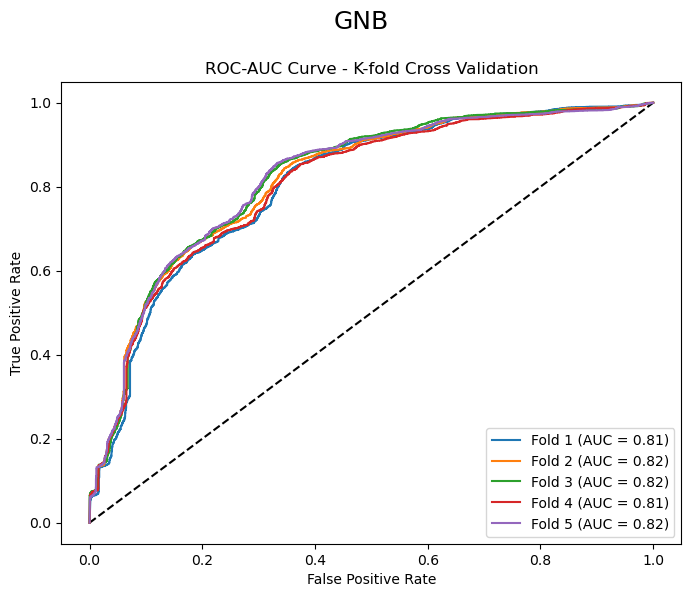


Above plot results:
  ID	Algorithm	train score[%] 	val score[%]
   1.	GNB            81.451625%	 81.235409%



Next Model:


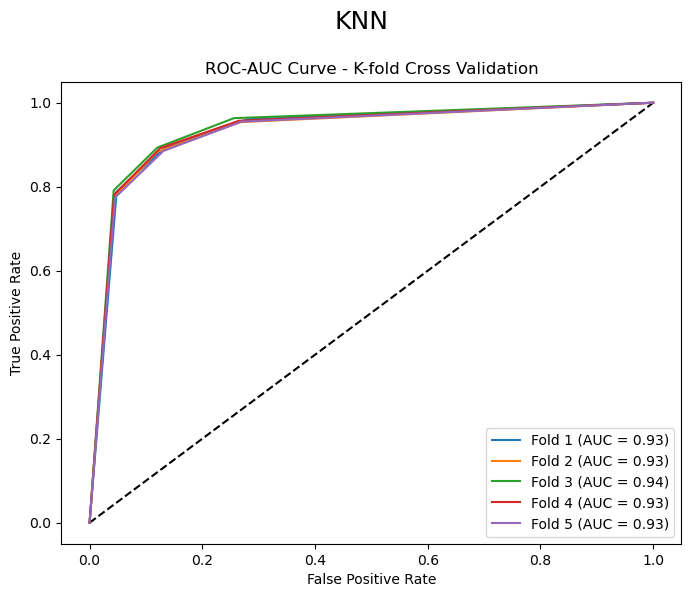


Above plot results:
  ID	Algorithm	train score[%] 	val score[%]
   2.	KNN            93.320724%	 93.381978%



Next Model:


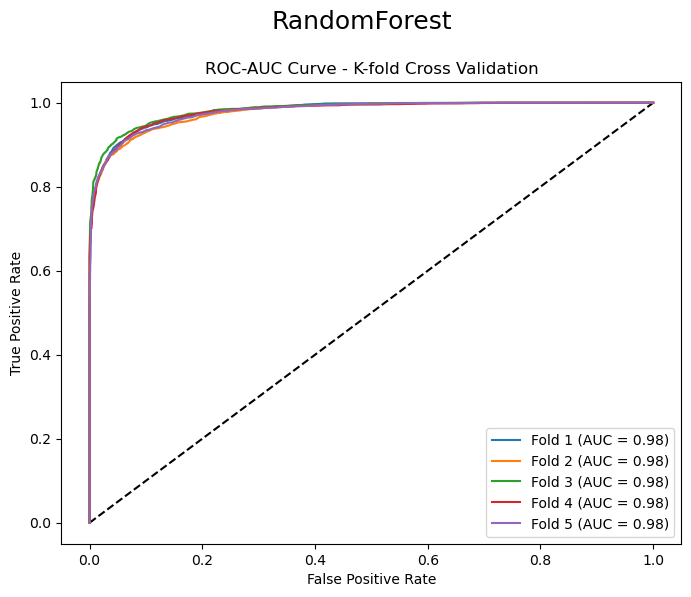


Above plot results:
  ID	Algorithm	train score[%] 	val score[%]
   3.	RandomForest   98.030044%	 95.542460%



Next Model:


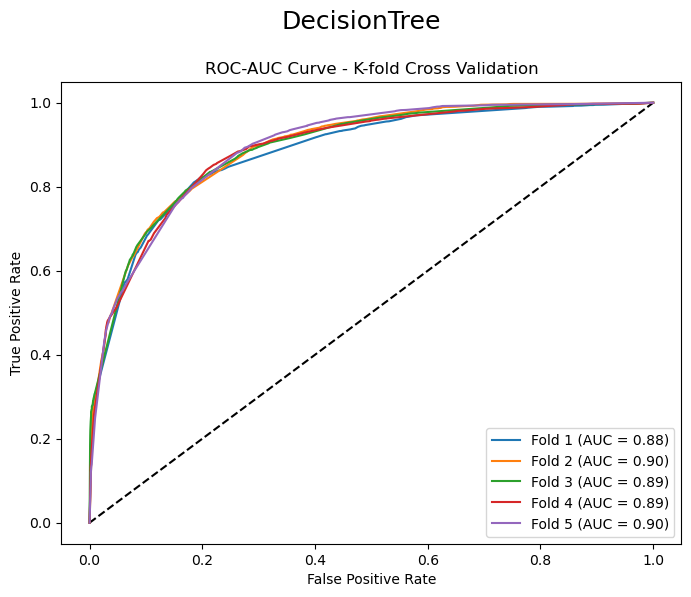


Above plot results:
  ID	Algorithm	train score[%] 	val score[%]
   4.	DecisionTree   89.124101%	 83.520368%



Next Model:

Most effective algorithm is RandomForest with a 95.542460 % success

Identifying false positive and false negative rates (takes longer for certain algorithms):


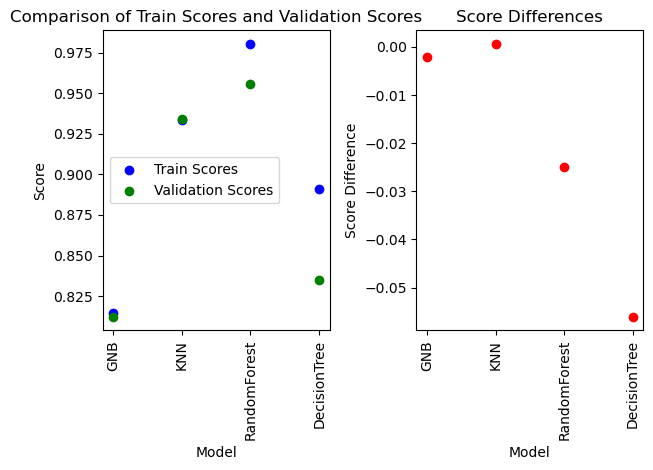

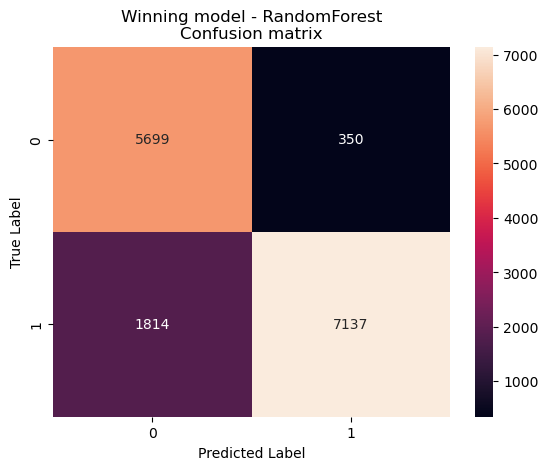

Winning model - RandomForest
Confusion matrix :
 [[5699  350]
 [1814 7137]]
False positive rate: 5.79%
False negative rate: 20.27%


In [94]:
winning_model = model_evaluation('ALL', X_train, X_validation, y_train, y_validation, feature_indices_dict)

### Feature Importance Analysis:

After Finding that our best model is the Random Forest Model, we wanted to analize the feature importance in this model and try to understand which features are the most imprtant for us:

In [95]:
def plot_feature_importance(model, X_train, feature_names=None):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    sorted_feature_names = [feature_names[i] for i in indices]

    plt.figure()
    plt.title("Feature Importances")
    plt.bar(range(X_train.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train.shape[1]), sorted_feature_names, rotation=90)
    plt.tight_layout()
    plt.show()
    top_indices = np.argsort(importances)[::-1][:15]

    # Print the contribution of each top feature
    print("Top 15 Feature Contributions:")
    for i, feature_index in enumerate(top_indices):
        feature_name = sorted_feature_names[i]
        importance = importances[feature_index]
        print(f"{feature_name}: {importance:.4f}")

    return top_indices

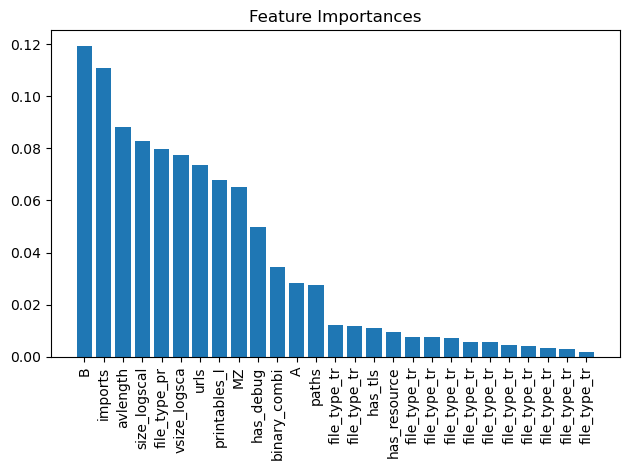

Top 15 Feature Contributions:
B: 0.1194
imports: 0.1108
avlength: 0.0883
size_logscal: 0.0827
file_type_pr: 0.0797
vsize_logsca: 0.0773
urls: 0.0737
printables_l: 0.0680
MZ: 0.0651
has_debug: 0.0500
binary_combi: 0.0344
A: 0.0281
paths: 0.0277
file_type_tr: 0.0122
file_type_tr: 0.0120


In [96]:
feature_names = [name[:12] for name in final_train_data.columns.tolist()]
top_indices = plot_feature_importance(ALGORITHMS['RandomForest'], X_train, feature_names)


Interestingly, we observed that the categorical features we created had the least impact on the model's performance. Our newly constructed binary feature ranked 11th in terms of contribution, with a score of 0.0344, and the unknown feature B emerged as the most influential, despite its ambiguous meaning.

In future endeavors, an approach to enhance our models could involve evaluating the cumulative contribution of features and selecting those that collectively account for 0.99 of the model's performance. This strategy would offer benefits such as dimensionality reduction, mitigating overfitting, and improving runtime efficiency. (Plots of this chapter are in Appendix R)

# Part 5- Predict test data

In [97]:
def predict_and_save_results(model, test_file, output_file, train_dict):
    # Load the test data from the file
    test_data = pd.read_csv(test_file)
    
    # Create a DataFrame with 'sha256' column
    results_df = pd.DataFrame({'sha256': test_data['sha256']})
    
    test_data = implementing_pre_process_test(test_data, train_dict, True)
    
    # Perform predictions on the test data
    predictions = model.predict_proba(test_data.values)
    
    # Add the 'prediction_proba' column to the results DataFrame
    results_df['predict_proba'] = predictions[:, 1]
    
    # Save the results to a new CSV file
    results_df.to_csv(output_file, index=False)

In [98]:
# # Example usage
# winning_model.fit(X_train, y_train)
# train_file = 'train.csv'
# test_file = 'test.csv'
# output_file = 'results_18.csv'
# predict_and_save_results(winning_model, test_file, output_file, train_dict)

# Pipeline

In [99]:
train_file = 'train.csv'
test_file = 'test.csv'
output_file = 'results_18.csv'

In [100]:
def pipeline(train_file, test_file, output_file):
    pipeline_train_data = pd.read_csv(train_file)
    # Splitting the train data to train and test, to have supervized test data before pre-processing
    pipeline_train_data, pipeline_validation_data = train_test_split(pipeline_train_data, test_size=0.25, random_state=42, shuffle=True)

    pipeline_final_train_data, pipeline_train_dict = implementing_pre_process_train(pipeline_train_data)
    pipeline_X_train, pipeline_y_train = pipeline_final_train_data.values[:,:-1], pipeline_final_train_data.values[:, -1]

    pipeline_final_val_data = implementing_pre_process_test(pipeline_validation_data, pipeline_train_dict, False)
    pipeline_X_validation, pipeline_y_validation = pipeline_final_val_data.values[:,:-1], pipeline_final_val_data.values[:, -1]

    pipeline_knn_best_params = choose_knn_params(pipeline_X_train, pipeline_y_train)
    pipeline_dt_best_params = choose_dt_best_params(pipeline_X_train, pipeline_y_train)
    pipeline_rf_best_params = choose_rf_best_params(pipeline_X_train, pipeline_y_train)

    pipeline_ALGORITHMS = {
    'GNB': GaussianNB(priors=priors),
    'KNN': KNeighborsClassifier(**pipeline_knn_best_params),
    'RandomForest': RandomForestClassifier(**pipeline_rf_best_params),
    'DecisionTree': tree.DecisionTreeClassifier(**pipeline_dt_best_params)
    }

    pipeline_feature_indices_dict = sfs_choosing_best_features(pipeline_final_train_data, pipeline_X_train, pipeline_y_train, pipeline_ALGORITHMS)

    pipeline_winning_model = model_evaluation('ALL', pipeline_X_train, pipeline_X_validation, pipeline_y_train, pipeline_y_validation, pipeline_feature_indices_dict)
    pipeline_winning_model.fit(pipeline_X_train, pipeline_y_train)

    feature_names = [name[:12] for name in final_train_data.columns.tolist()]
    top_indices = plot_feature_importance(ALGORITHMS['RandomForest'], X_train, feature_names)   

    predict_and_save_results(pipeline_winning_model, test_file, output_file, pipeline_train_dict)

Number of outliers detected 'normal distribution': 648
Number of data points after handling outliers: 45000
Number of outliers replaced 'normal distribution': 229
Number of data points after handling outliers: 15000
Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 3}
Fitting 3 folds for each of 50 candidates, totalling 150 fits

ALL specified: testing all available algorithms then selecting most accurate.


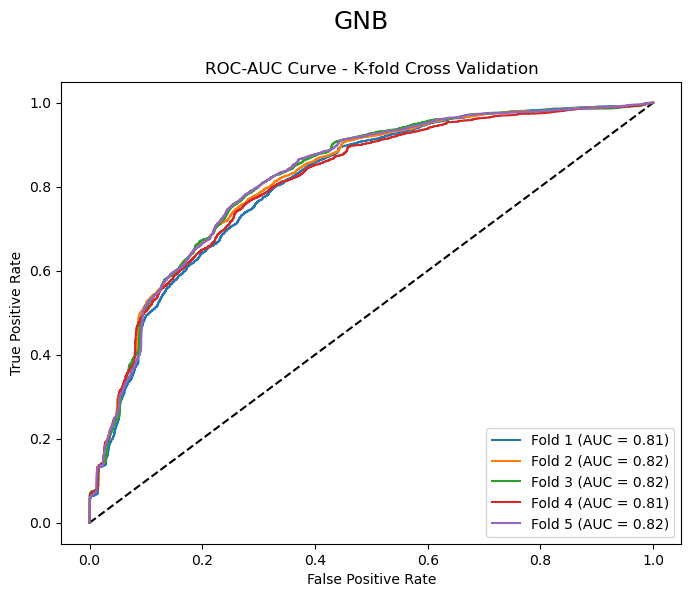


Above plot results:
  ID	Algorithm	train score[%] 	val score[%]
   1.	GNB            81.533496%	 81.198794%



Next Model:


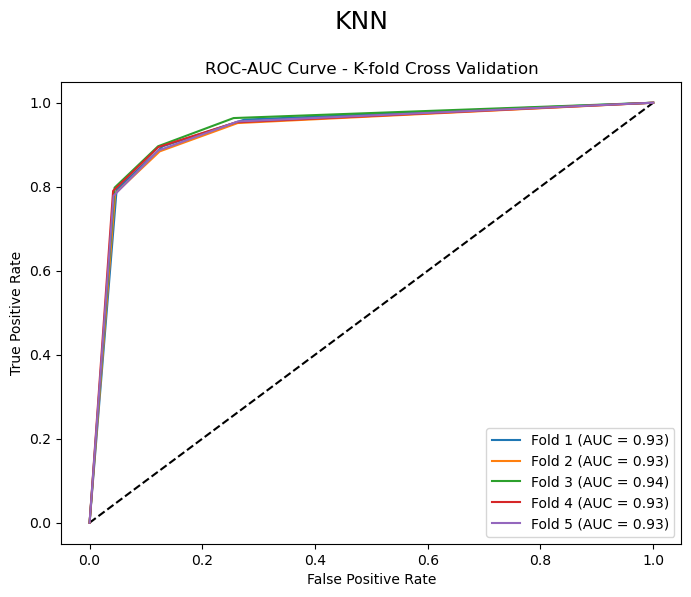


Above plot results:
  ID	Algorithm	train score[%] 	val score[%]
   2.	KNN            93.387884%	 93.599326%



Next Model:


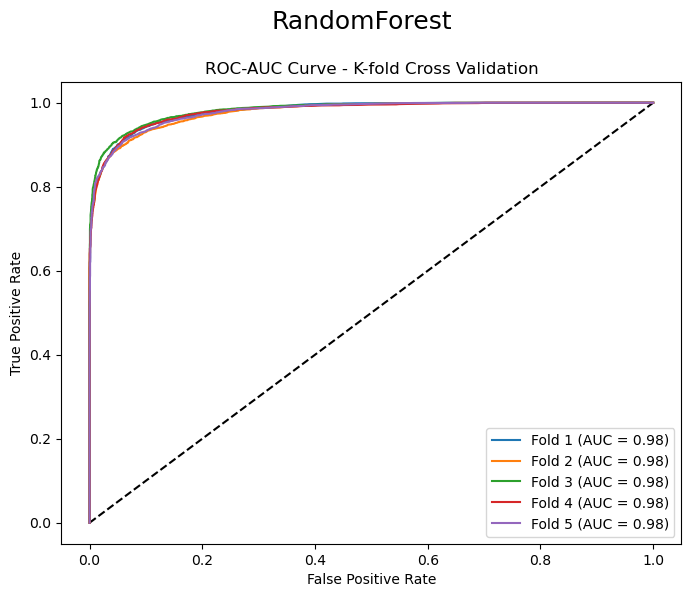


Above plot results:
  ID	Algorithm	train score[%] 	val score[%]
   3.	RandomForest   98.037546%	 95.513944%



Next Model:


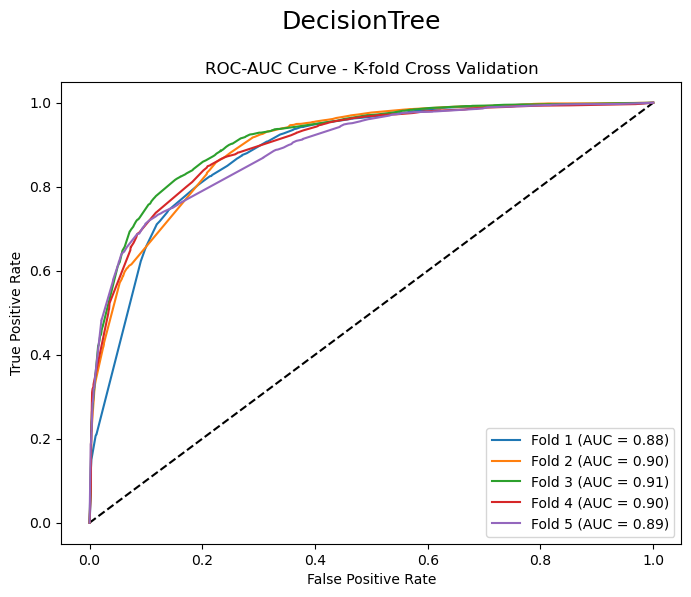


Above plot results:
  ID	Algorithm	train score[%] 	val score[%]
   4.	DecisionTree   89.816430%	 80.685744%



Next Model:

Most effective algorithm is RandomForest with a 95.513944 % success

Identifying false positive and false negative rates (takes longer for certain algorithms):


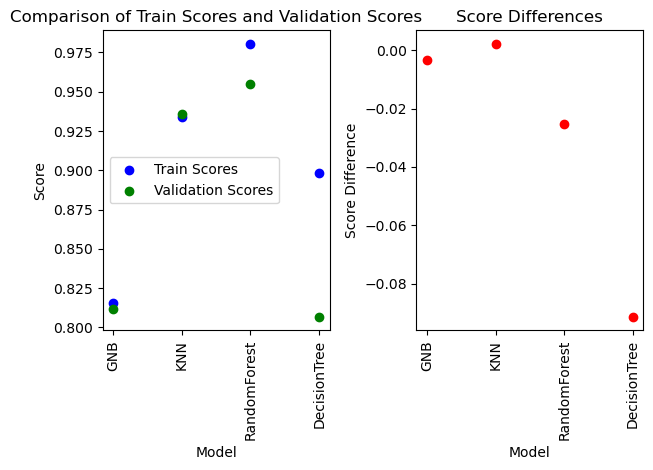

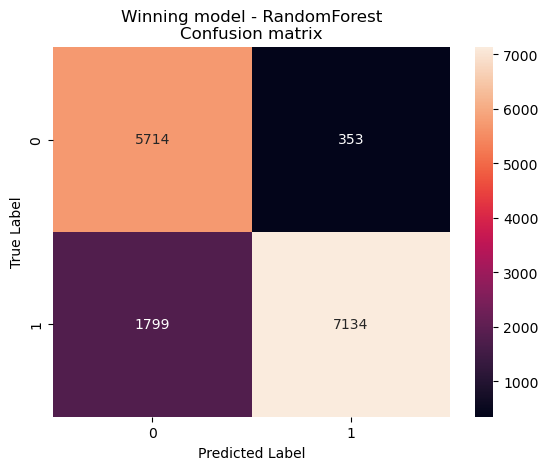

Winning model - RandomForest
Confusion matrix :
 [[5714  353]
 [1799 7134]]
False positive rate: 5.82%
False negative rate: 20.14%


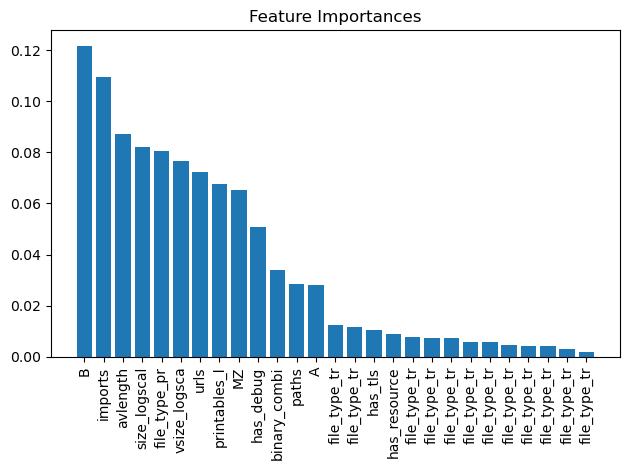

Top 15 Feature Contributions:
B: 0.1217
imports: 0.1095
avlength: 0.0870
size_logscal: 0.0822
file_type_pr: 0.0805
vsize_logsca: 0.0768
urls: 0.0724
printables_l: 0.0677
MZ: 0.0654
has_debug: 0.0507
binary_combi: 0.0339
paths: 0.0285
A: 0.0281
file_type_tr: 0.0124
file_type_tr: 0.0116
Number of outliers replaced 'normal distribution': 272
Number of data points after handling outliers: 18000


In [101]:
pipeline(train_file, test_file, output_file)